In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import itertools
import pickle

from matplotlib import rcParams
from scipy.optimize import curve_fit, root_scalar
from scipy.signal import savgol_filter


In [4]:
rcParams['figure.figsize'] = 12, 5
plt.rcParams.update({'font.size': 15})
plotsize = (10, 6)
legend_size = 12
rcParams["savefig.dpi"] = 300
rcParams["savefig.bbox"] = 'tight'

# 1. Import and Plot Spectroscopy Data

### 1.1 Define Functions

In [5]:
def get_data(filename):
    data1 = loadmat(filename)
    transAmpData1 = data1['transamp']
    specAmpData1 = data1['specamp']
    specPhaseData1 = data1['specphase']
    specFreqVector1 = data1['specfreq']
    volts1 = data1['voltage_vector']

    Ylist = specFreqVector1
    Xlist0 = volts1
    Xlist = Xlist0

    Xlist = np.asarray(Xlist)
    Ylist = np.asarray(Ylist)*1e-9

    # Xlist = (Xlist - voltOffSet +VoltPerFlux*center)/VoltPerFlux

    X,Y = np.meshgrid(Xlist,Ylist)

    ### make copies of spec data 
    phase = specPhaseData1.copy()
    amp = specAmpData1.copy()

    ### remove average for better plotting
    for i in range(0, len(phase[:,1]) ):
        phase[i,:] = phase[i,:] - np.mean(phase[i,:])
        amp[i,:] = amp[i,:] - np.mean(amp[i,:])
    amp = amp#[::-1]
    Z = amp.copy()
    Z = np.asarray(Z)
    Z = np.transpose(Z)
    
    return(X, Y, Z)

In [6]:
def plot_spec_data(voltage_data, frequency_data, transmission_data, qubit_name=None, fit_voltages=None, fit_frequencies=None, vmin=-2, vmax=10):
    

    # Initialize the plot
    plt.figure()


    # To store axis limits
    voltage_min_all = float('inf')
    voltage_max_all = float('-inf')
    frequency_min_all = float('inf')
    frequency_max_all = float('-inf')

    for i in range(len(transmission_data)):
        voltage_min = voltage_data[i][0, 0]
        voltage_max = voltage_data[i][0, -1]
        voltage_step = voltage_data[i][0, 1] - voltage_data[i][0, 0]

        frequency_min = frequency_data[i][0, 0]
        frequency_max = frequency_data[i][-1, 0]
        frequency_step = frequency_data[i][1, 0] - frequency_data[i][0, 0]

        extent = (voltage_min - voltage_step / 2, 
                  voltage_max + voltage_step / 2, 
                  frequency_min - frequency_step / 2, 
                  frequency_max + frequency_step / 2)

        plt.imshow(transmission_data[i], interpolation='none', vmin=vmin, vmax=vmax, origin='lower', cmap='summer', aspect='auto', extent=extent, alpha=0.7)


        # Update the overall min/max for voltage and frequency
        voltage_min_all = min(voltage_min_all, extent[0])
        voltage_max_all = max(voltage_max_all, extent[1])
        frequency_min_all = min(frequency_min_all, extent[2])
        frequency_max_all = max(frequency_max_all, extent[3])

    # Set the overall axis limits
    plt.xlim(voltage_min_all, voltage_max_all)
    plt.ylim(frequency_min_all, frequency_max_all)

    if fit_frequencies is not None and fit_voltages is not None:
        plt.plot(fit_voltages, fit_frequencies, marker='o',linestyle='', color='red', ms=2)
        
    
    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (MHz)')
    plt.colorbar(label='Transmission (a.u.)')
    
    title = 'Qubit frequency vs voltage'
    if qubit_name is not None:
        title = f'{qubit_name} frequency vs voltage'
    plt.title(title)
    plt.show()


### 1.2 Plot Spec Data

In [167]:
qubits = ['Q1', 'Q2', 'Q3', 'Q4']

filenames_Q1 = []

filenames_Q2 = ['V://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax062724/2Tone4Qubit_NR_20240627_1348.mat', 
                'V://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax062724/2Tone4Qubit_NR_20240627_1602.mat',
                'V://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax070124/2Tone4Qubit_NR_20240701_0942.mat',
                'V://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax070124/2Tone4Qubit_NR_20240701_0957.mat']

filenames_Q3 = ['V://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax062724/2Tone4Qubit_NR_20240627_0803.mat', 
                'V://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax062724/2Tone4Qubit_NR_20240627_0915.mat',
                'V://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax070124/2Tone4Qubit_NR_20240701_0835.mat',
                'V://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax070124/2Tone4Qubit_NR_20240701_0905.mat']

filenames_Q4 = ['V://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax062824/2Tone4Qubit_NR_20240628_2056.mat', 
                'V://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax062824/2Tone4Qubit_NR_20240628_2210.mat', 
                'V://QSimMeasurements/Measurements/4Q_Triangle_Lattice/pnax062824/2Tone4Qubit_NR_20240628_2346.mat']

qubit_to_spec_filenames = {'Q1': filenames_Q1,
                           'Q2': filenames_Q2,
                           'Q3': filenames_Q3,
                           'Q4': filenames_Q4}


qubit_to_voltage_data_all = {}
qubit_to_frequency_data_all = {}
qubit_to_transmission_data_all = {}




for qubit in qubits:
    
    voltage_data_all = []
    frequency_data_all = []
    transmission_data_all = []
    
    for file in qubit_to_spec_filenames[qubit]:
        X, Y, Z = get_data(file)
        voltage_data_all.append(X)
        frequency_data_all.append(Y)
        transmission_data_all.append(Z)
        
    qubit_to_voltage_data_all[qubit] = voltage_data_all
    qubit_to_frequency_data_all[qubit] = frequency_data_all    
    qubit_to_transmission_data_all[qubit] = transmission_data_all    

In [168]:
# points on plots x axis
num_voltage_points = 1001

voltage_min = min([np.min(array) for array in voltage_data_all])
voltage_max = max([np.max(array) for array in voltage_data_all])

voltage_axis = np.linspace(voltage_min, voltage_max, num_voltage_points)
voltage_step = voltage_axis[1] - voltage_axis[0]

frequency_min = min([np.min(array) for array in frequency_data_all])
frequency_max = max([np.max(array) for array in frequency_data_all])

num_frequency_points = 101
frequency_axis = np.linspace(frequency_min, frequency_max, num_frequency_points)
frequency_step = frequency_axis[1] - frequency_axis[0]

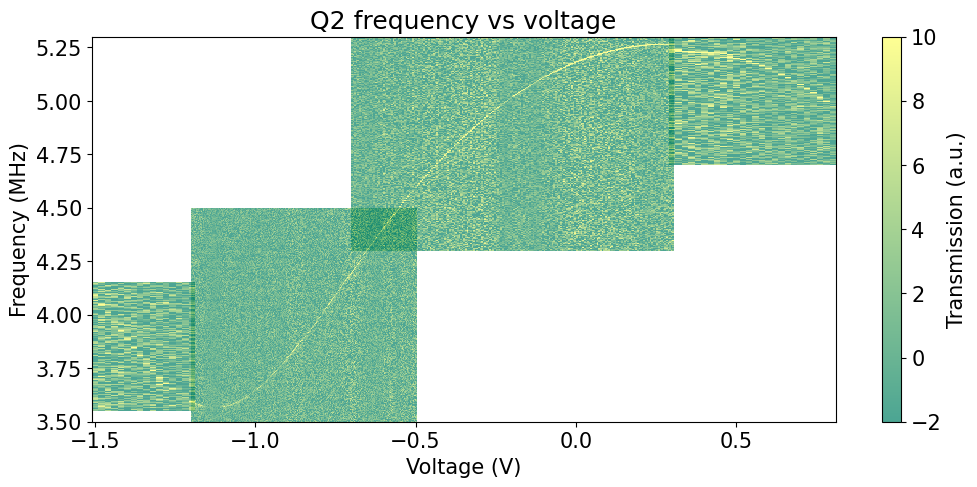

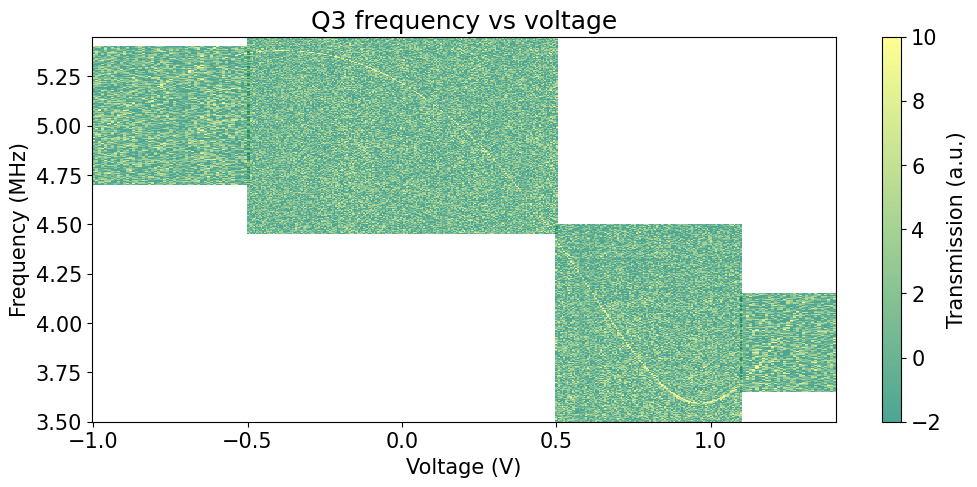

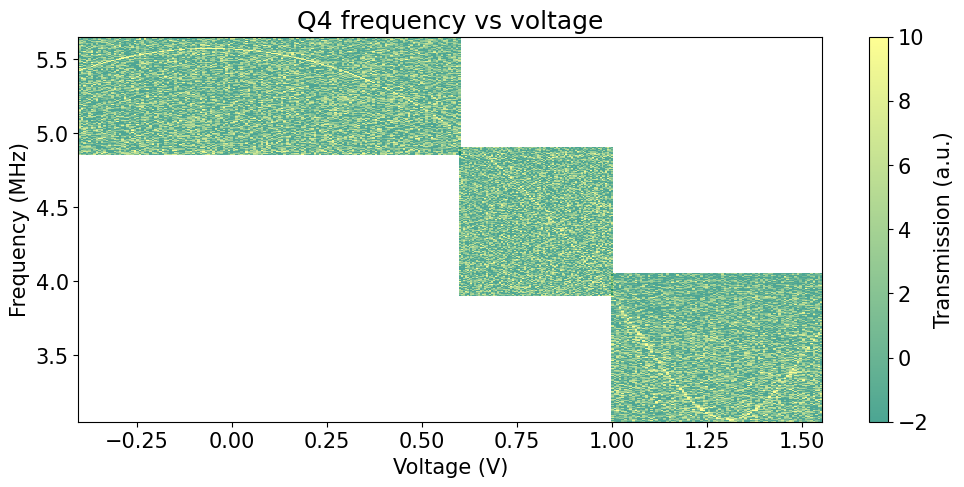

In [169]:
for qubit in qubits:
    voltage_data_all = qubit_to_voltage_data_all[qubit]
    frequency_data_all = qubit_to_frequency_data_all[qubit]
    transmission_data_all = qubit_to_transmission_data_all[qubit]
    
    if len(voltage_data_all) > 0:
        plot_spec_data(voltage_data_all, frequency_data_all, transmission_data_all, qubit_name=qubit)


# 2. Find Peaks

### 2.1 Fit to Lorentzian

In [170]:
def lorentzian_fit(x, x0, a, b, c):
    return a/(b+np.power((x-x0), 2))+c

In [171]:
def get_center_frequencies(voltage_data, frequency_data, transmission_data, start_index=5, frequency_index_span=100, plot_fits=False):
    '''
    :param frequency_index_span: number of points around peak to try fit
    '''
    
#     center_frequencies = np.zeros(voltage_data.shape[1])
#     center_frequency_errors = np.zeros(voltage_data.shape[0])
    center_frequencies = []
    center_frequency_errors = []
    voltage_points_with_fit = []
    
    voltages = voltage_data[0,:]
    
    if isinstance(start_index, int):
        start_indices = [start_index] * len(voltages)
    else:
        start_indices = list(start_index)
    
    for i in range(len(voltages)):
        
#         print(f'index: {i}')
        
        frequencies = frequency_data[:,0]
        # find peak
        if i >= len(start_indices):
            start_index = start_indices[-1]
        else:
            start_index = start_indices[i]
        row = transmission_data[start_index:,i]
        
        peak_index = np.argmax(row) + start_index
        center_frequency_guess = frequencies[peak_index]
        
        
        # fit to lorentzian
        # restrict fit in range span around peak

        restricted_frequencies = frequencies[max(peak_index - frequency_index_span//2, 0):min(peak_index + frequency_index_span//2, len(frequencies))]
        restricted_row = transmission_data[max(peak_index - frequency_index_span//2, 0):min(peak_index + frequency_index_span//2, len(frequencies)),i]
        
        # apply savgol filter
        
        filtered_row = savgol_filter(restricted_row, 7, 1)
        
        bounds = ([restricted_frequencies[0], 0, 0, -np.inf], [restricted_frequencies[-1], np.inf, np.inf, np.inf])
        initial_guess = [center_frequency_guess, 0.001, 0.0001, 0]
        try:
            popt, pcov = curve_fit(lorentzian_fit, restricted_frequencies, filtered_row, p0=initial_guess, bounds=bounds)
        except:
            # if it fails, plot the data it was trying to fit
            plt.plot(restricted_frequencies, filtered_row, linestyle='', marker='o', label='data')
            plt.plot(restricted_frequencies, lorentzian_fit(restricted_frequencies, *initial_guess), label='guess')
            plt.xlabel('Frequency (MHz)')
            plt.title(f'Lorentzian fit for index {i}')
            plt.axvline(center_frequency_guess, color='red')
            plt.legend()
            plt.show()
            
            print('Couldn\'t get a fit')
            
            # use max as the center frequency
            center_frequencies.append(restricted_frequencies[np.argmax(filtered_row)])
            voltage_points_with_fit.append(voltages[i])
            center_frequency_errors.append(frequencies[-1] - frequencies[0])
            
            
        else:
            
            center_frequencies.append(popt[0])

            perr = np.sqrt(np.diag(pcov))
            center_frequency_errors.append(perr[0])

            voltage_points_with_fit.append(voltages[i])
            
            if plot_fits:
                plt.plot(frequencies[start_index:], row, linestyle='', marker='o', label='data')

                fit_frequencies = np.linspace(frequencies[start_index], frequencies[-1], 1000)
                plt.plot(fit_frequencies, lorentzian_fit(fit_frequencies, *popt), label='fit')
                plt.axvline(center_frequency_guess, color='red')
                plt.legend()

                plt.xlabel('Frequency (MHz)')
                plt.title(f'Lorentzian fit for index {i}')
                plt.show()

                print(f'Center frequency is {popt[0]} MHz')
            
    return voltage_points_with_fit, center_frequencies, center_frequency_errors


In [172]:
qubit_to_voltages = {}
qubit_to_frequencies = {}

In [173]:
test_filenames = [r'C:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Jupyter Notebooks\crosstalk_calibration_gui\Q2_spectroscopy\2Tone4Qubit_NR_20240627_1348.mat',
                 r'C:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Jupyter Notebooks\crosstalk_calibration_gui\Q2_spectroscopy\2Tone4Qubit_NR_20240627_1602.mat',
                 r'C:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Jupyter Notebooks\crosstalk_calibration_gui\Q2_spectroscopy\2Tone4Qubit_NR_20240701_0942.mat',
                 r'C:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Jupyter Notebooks\crosstalk_calibration_gui\Q2_spectroscopy\2Tone4Qubit_NR_20240701_0957.mat']

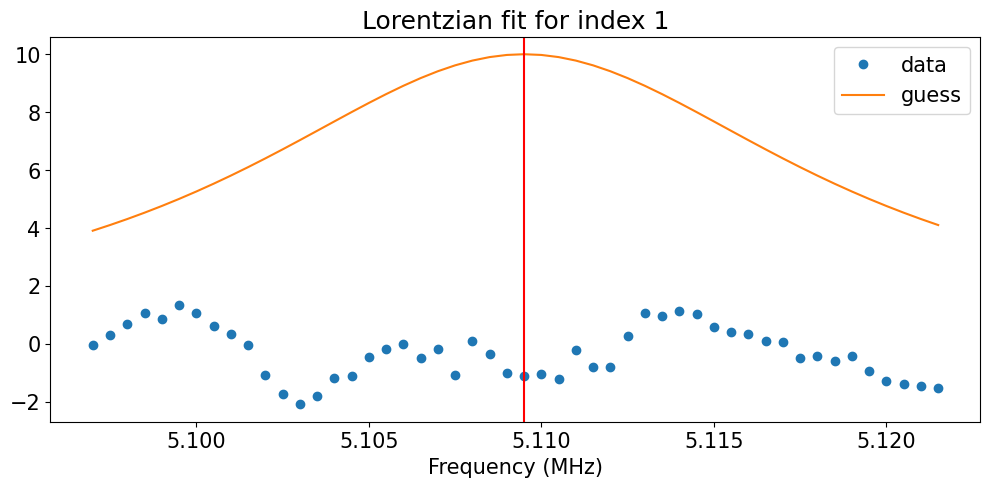

Couldn't get a fit


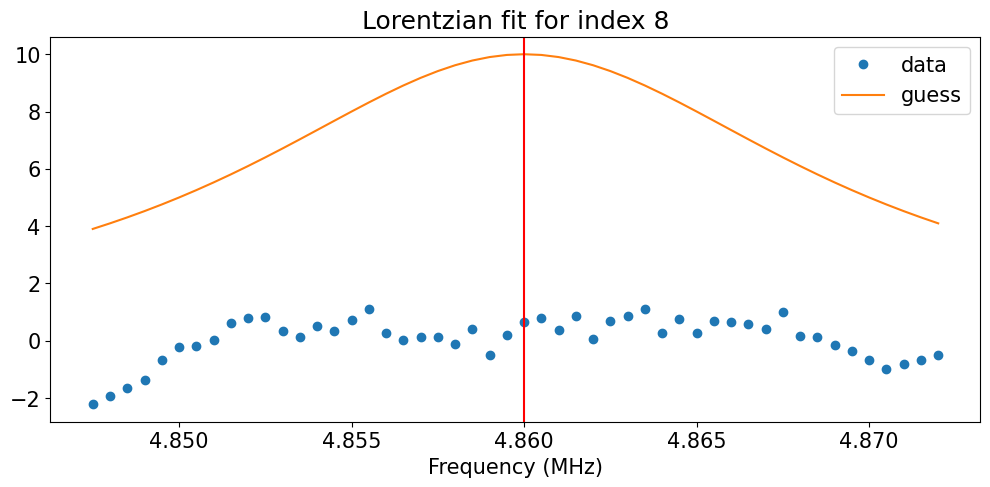

Couldn't get a fit


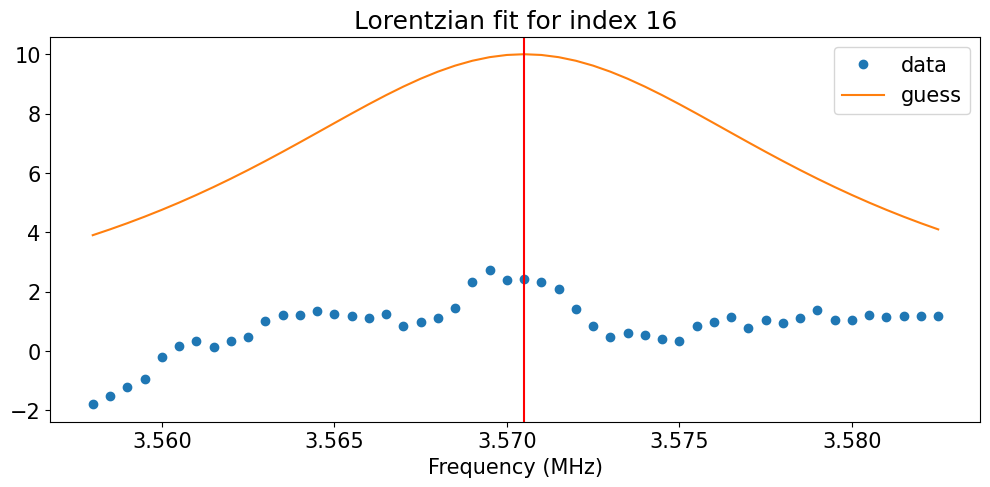

Couldn't get a fit


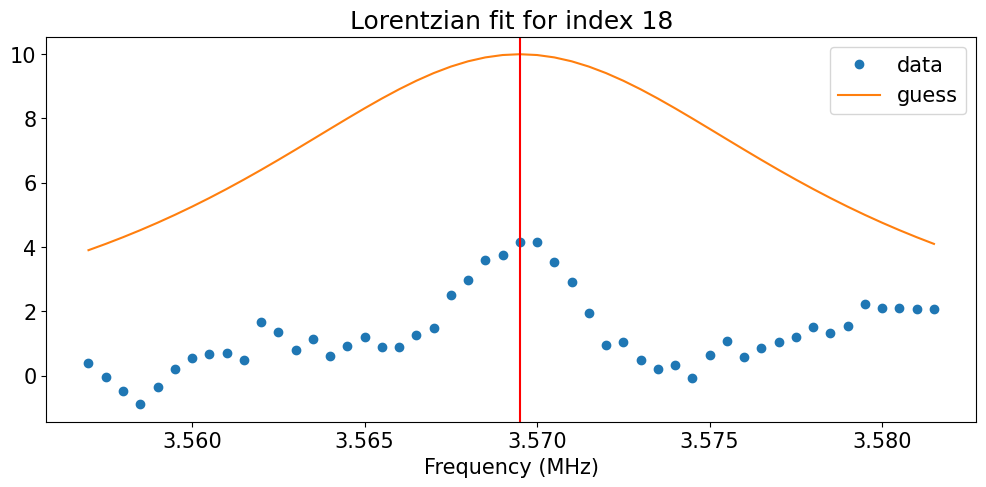

Couldn't get a fit


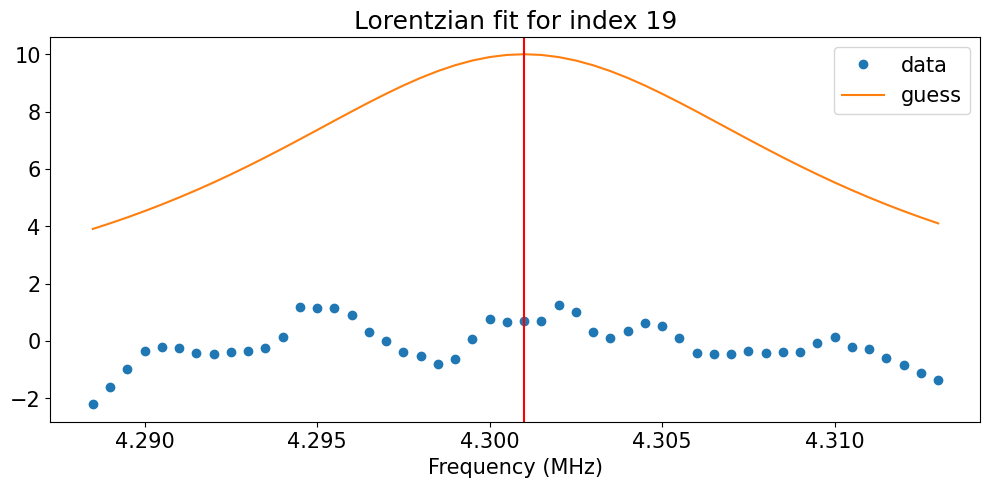

Couldn't get a fit


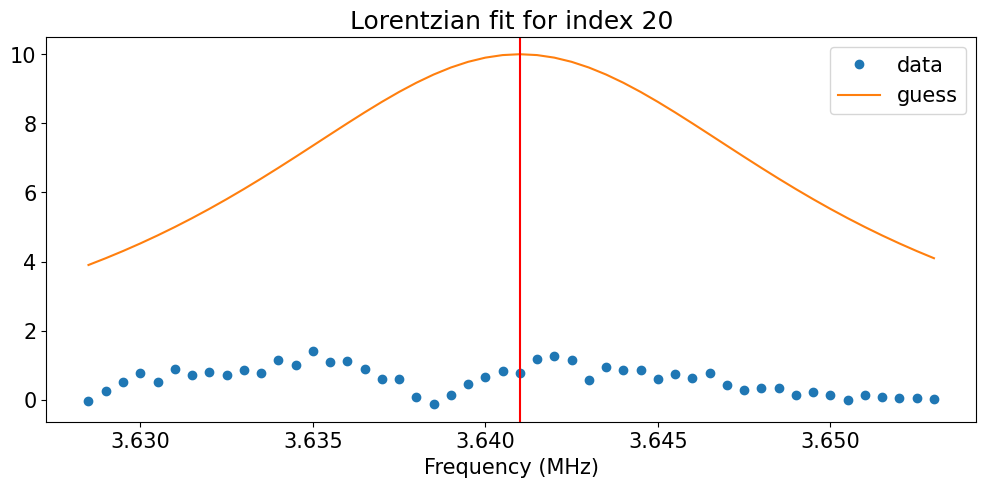

Couldn't get a fit


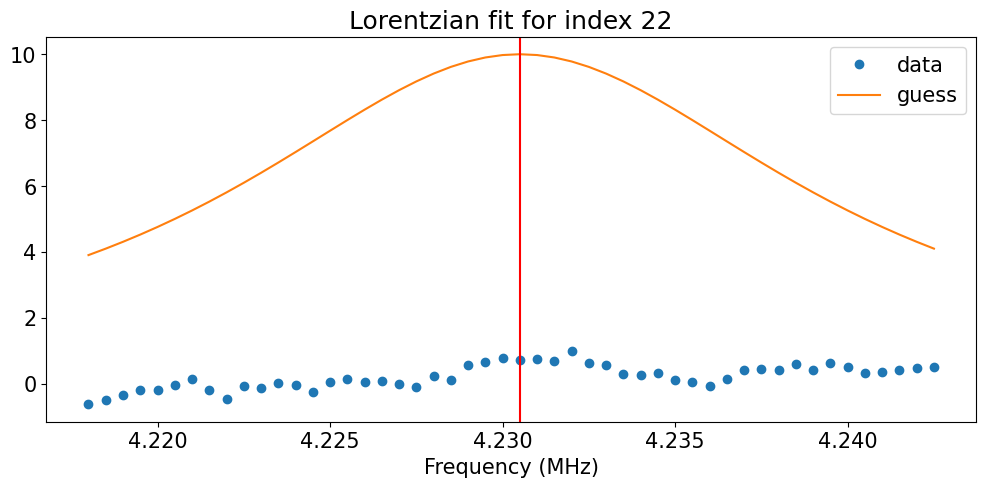

Couldn't get a fit


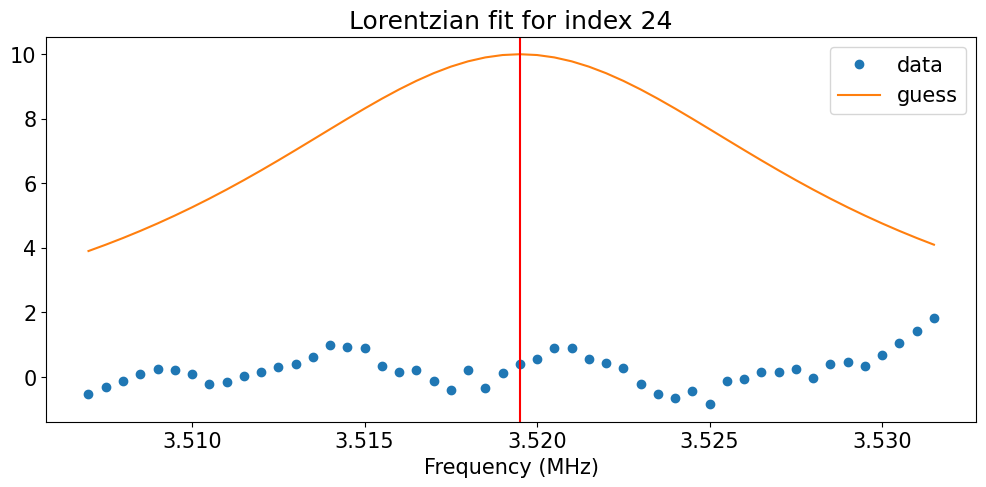

Couldn't get a fit


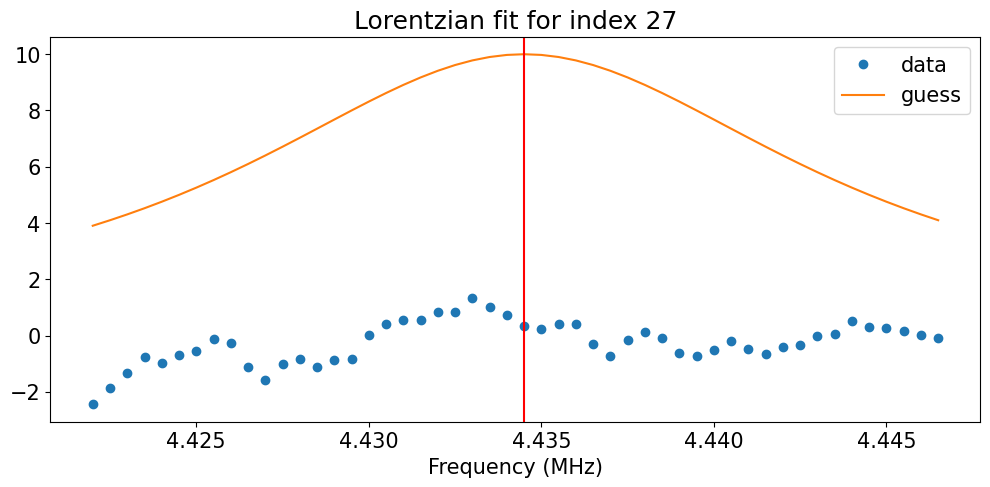

Couldn't get a fit


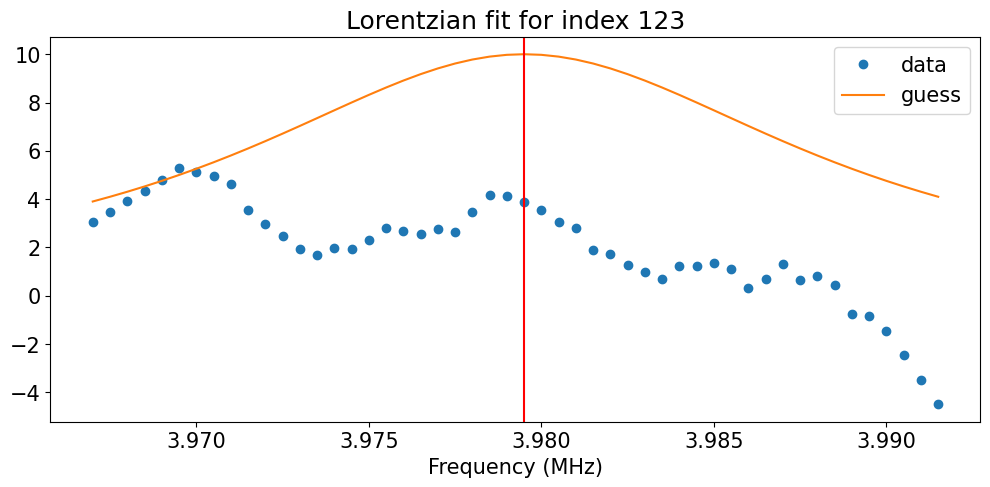

Couldn't get a fit


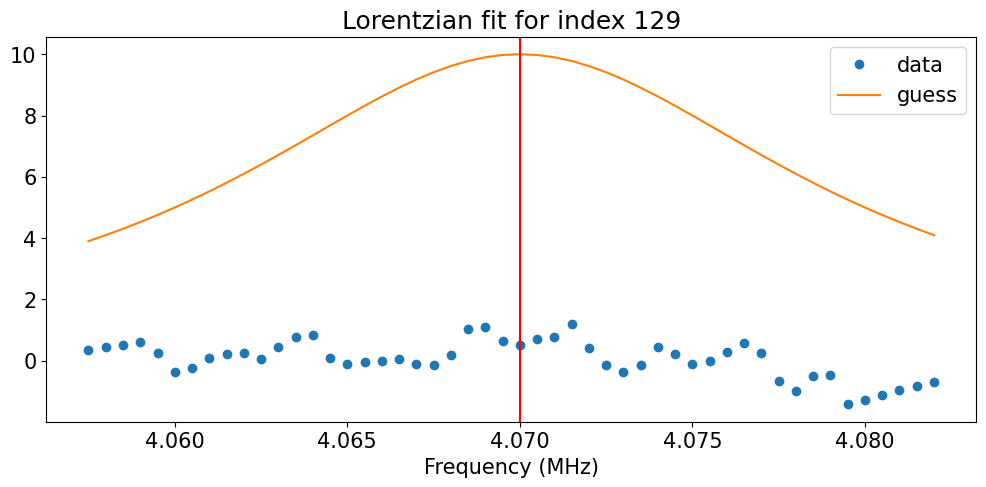

Couldn't get a fit


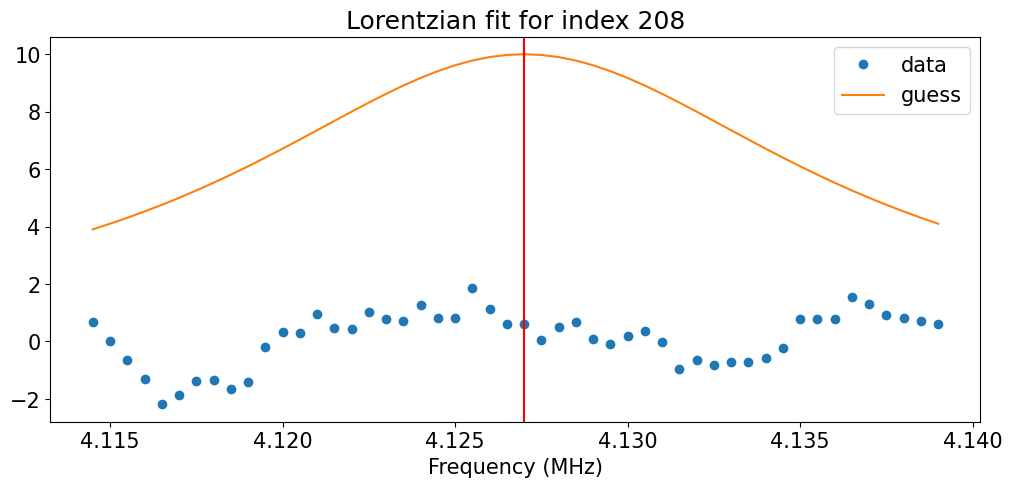

Couldn't get a fit


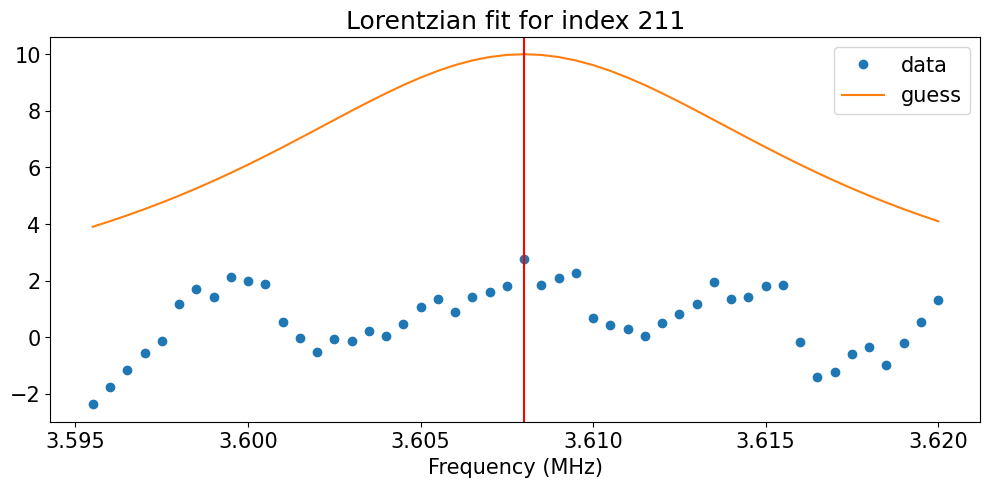

Couldn't get a fit


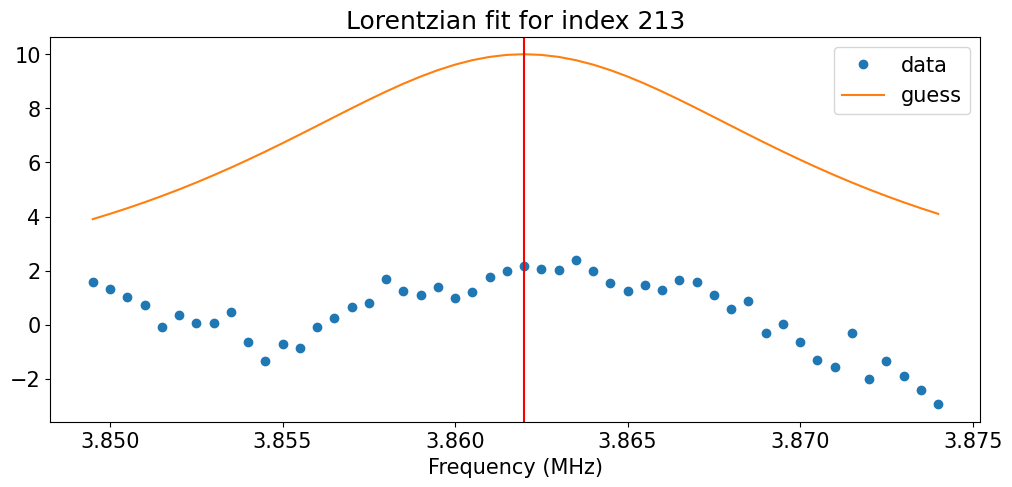

Couldn't get a fit


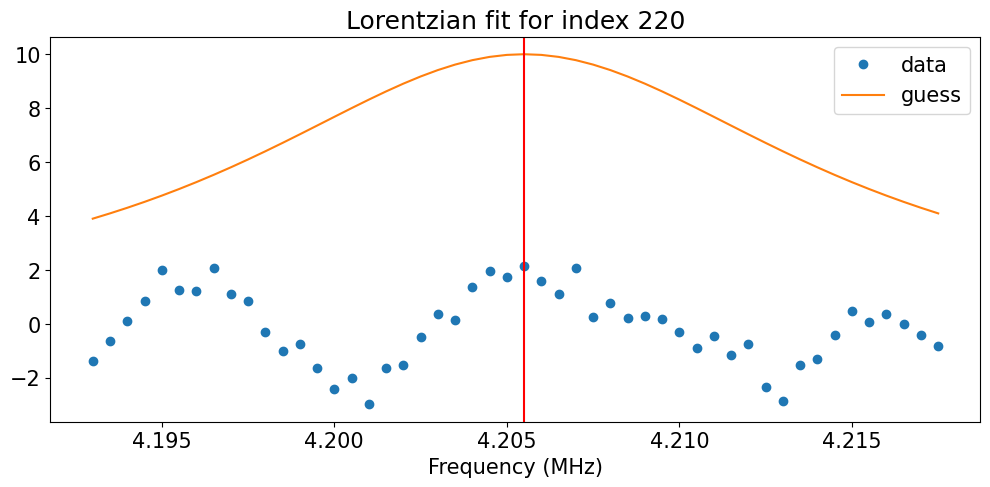

Couldn't get a fit


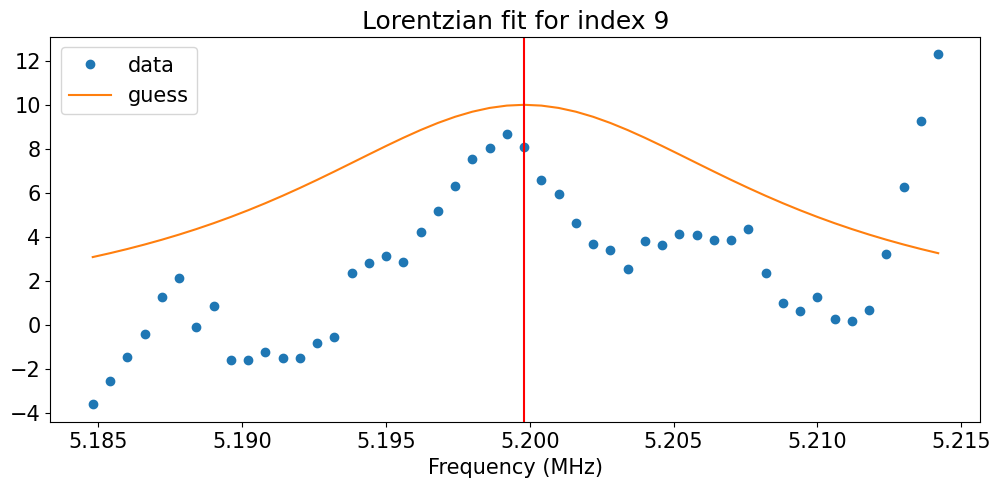

Couldn't get a fit


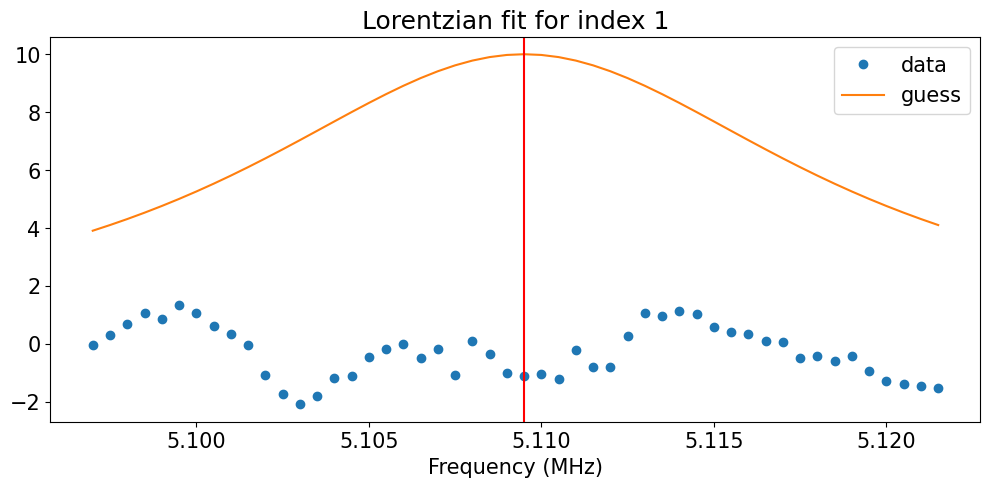

Couldn't get a fit


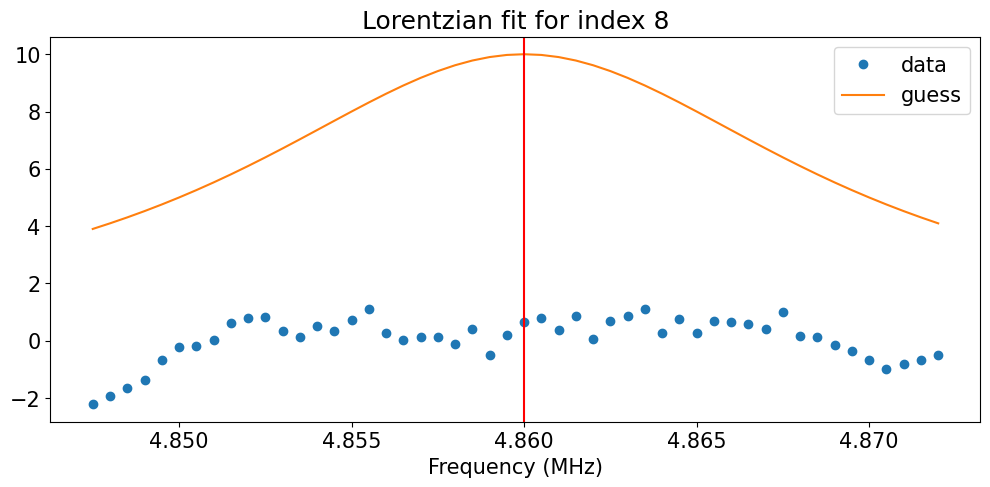

Couldn't get a fit


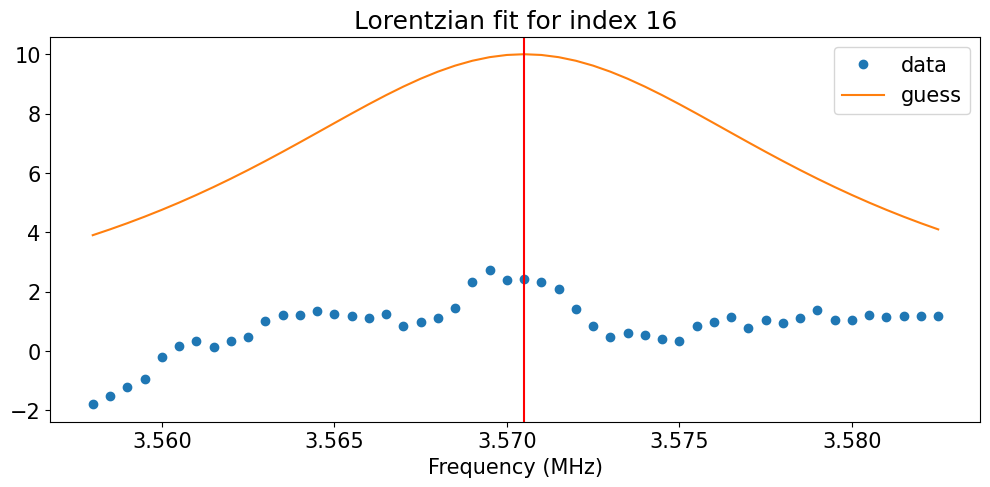

Couldn't get a fit


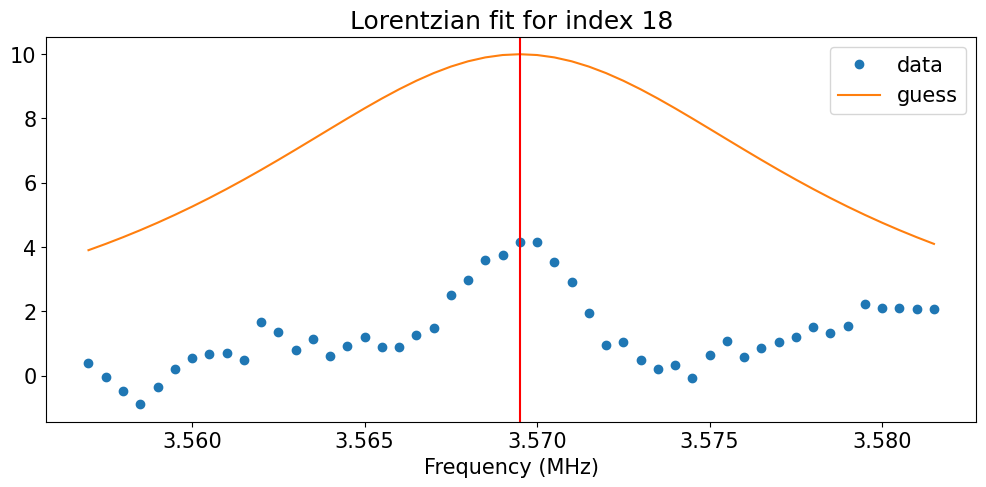

Couldn't get a fit


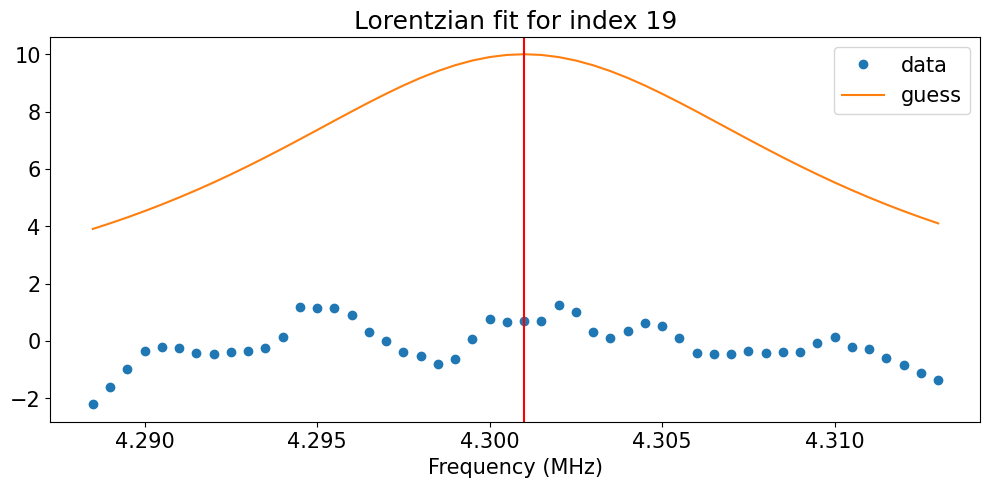

Couldn't get a fit


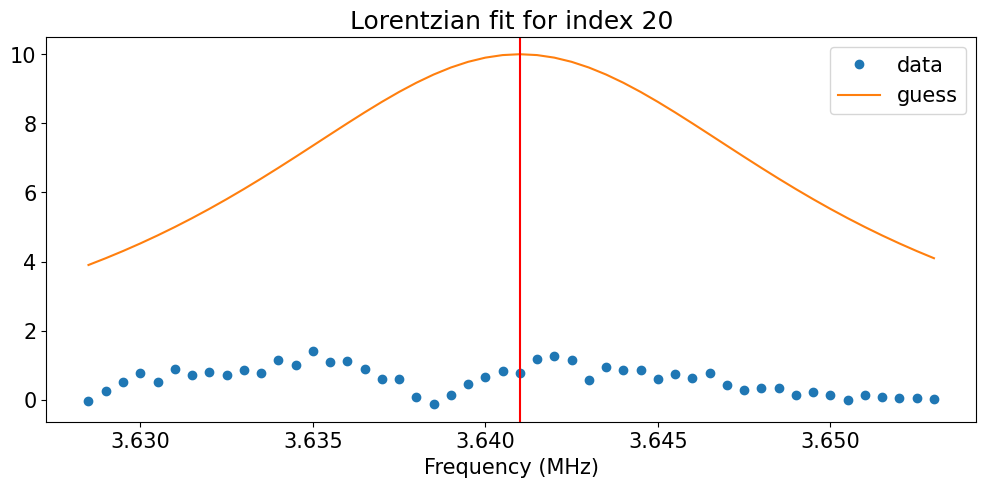

Couldn't get a fit


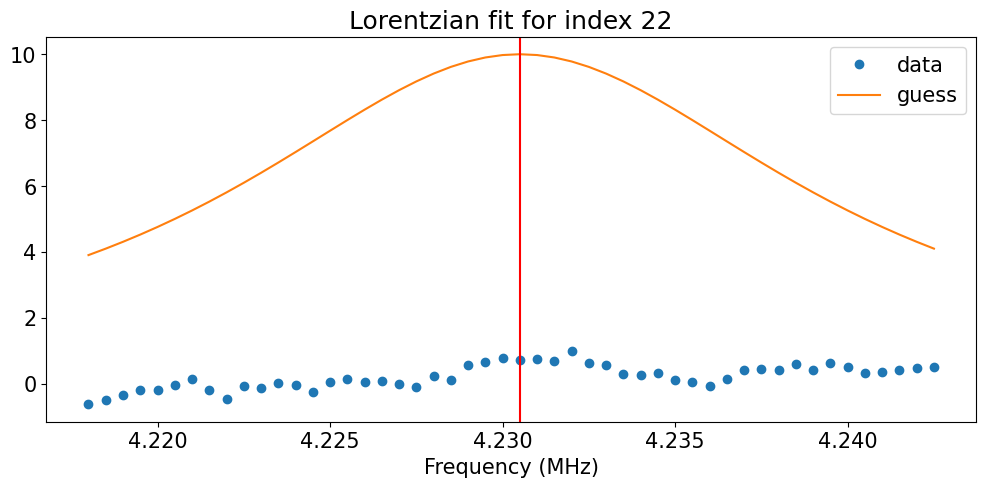

Couldn't get a fit


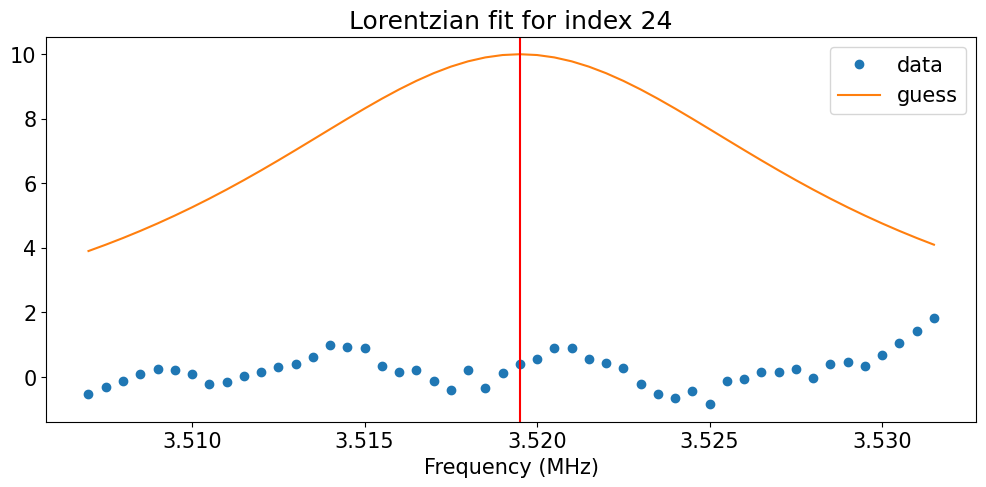

Couldn't get a fit


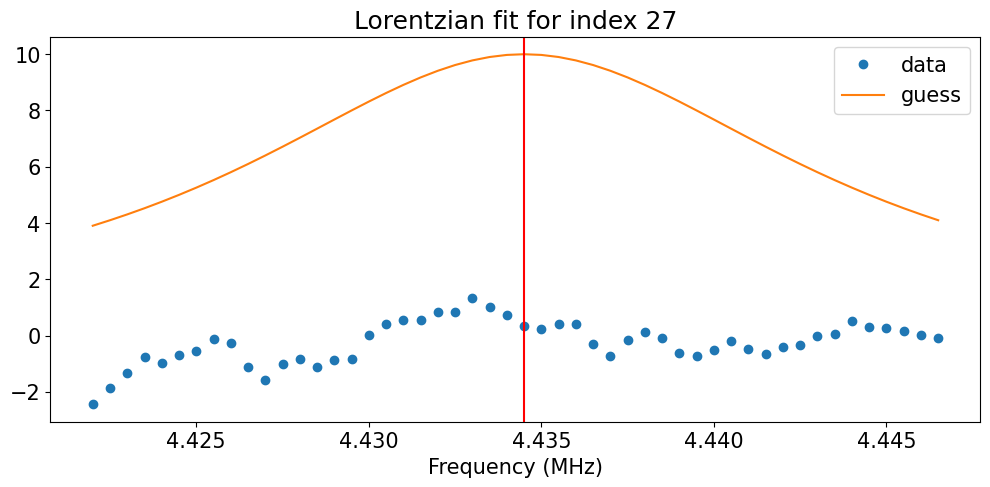

Couldn't get a fit


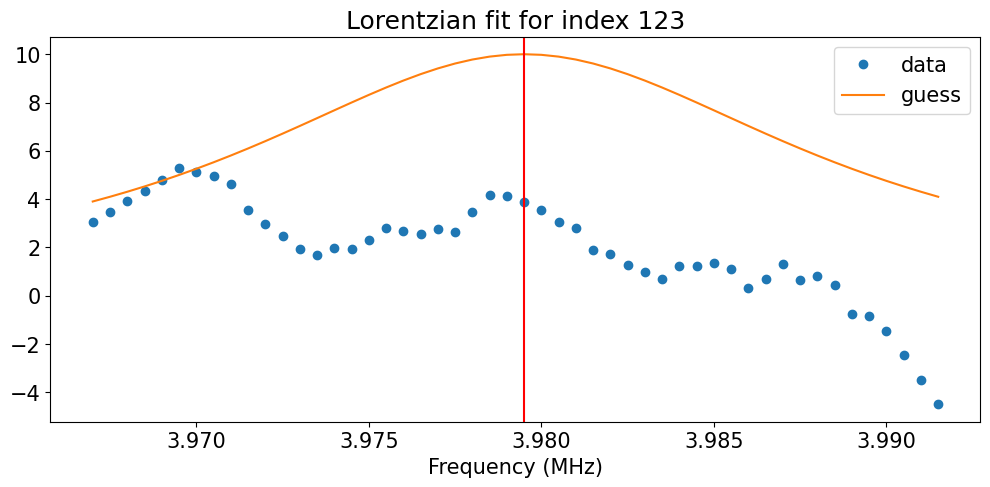

Couldn't get a fit


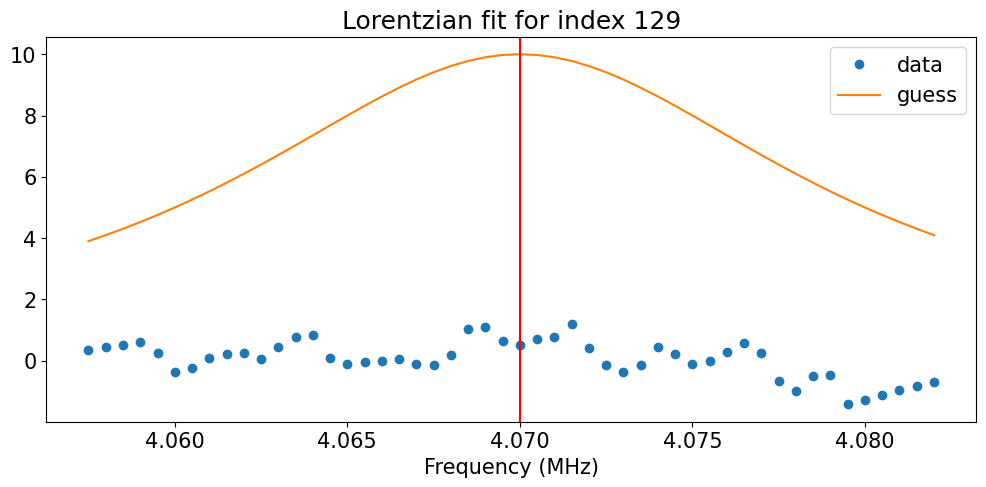

Couldn't get a fit


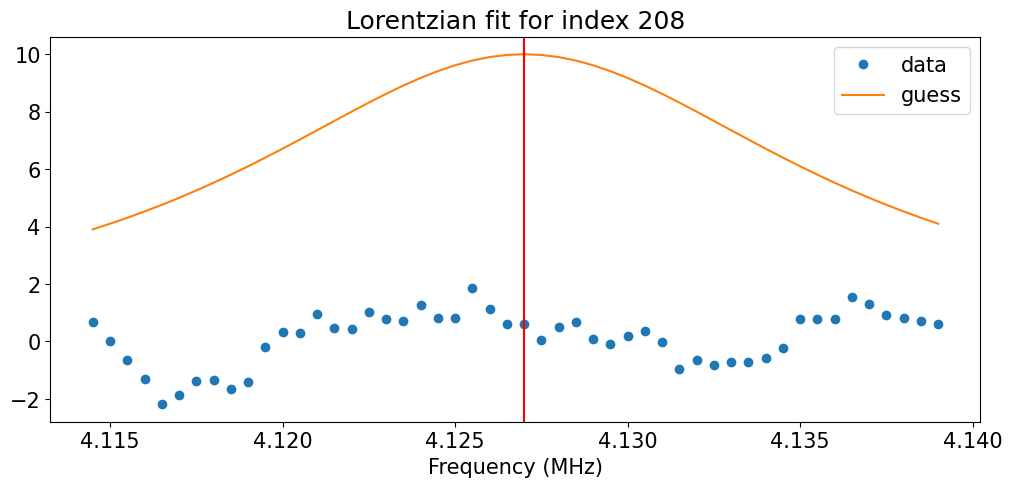

Couldn't get a fit


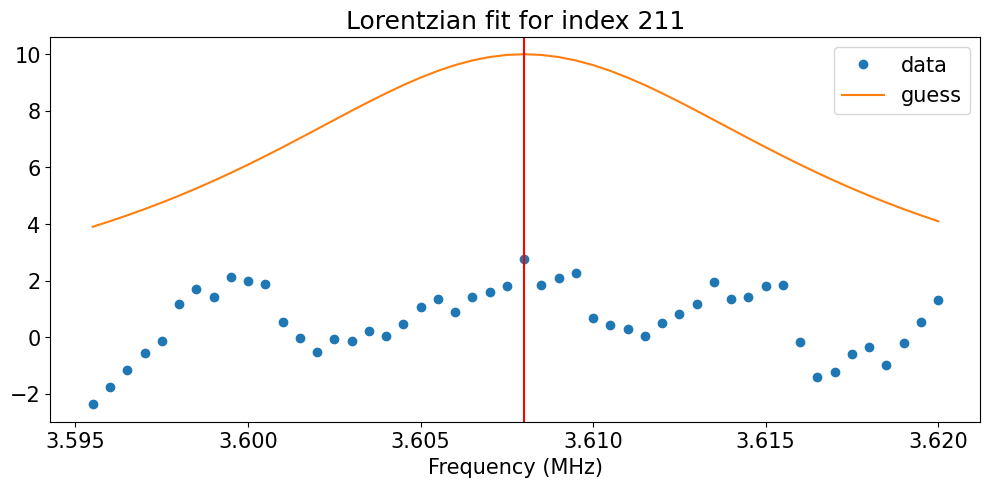

Couldn't get a fit


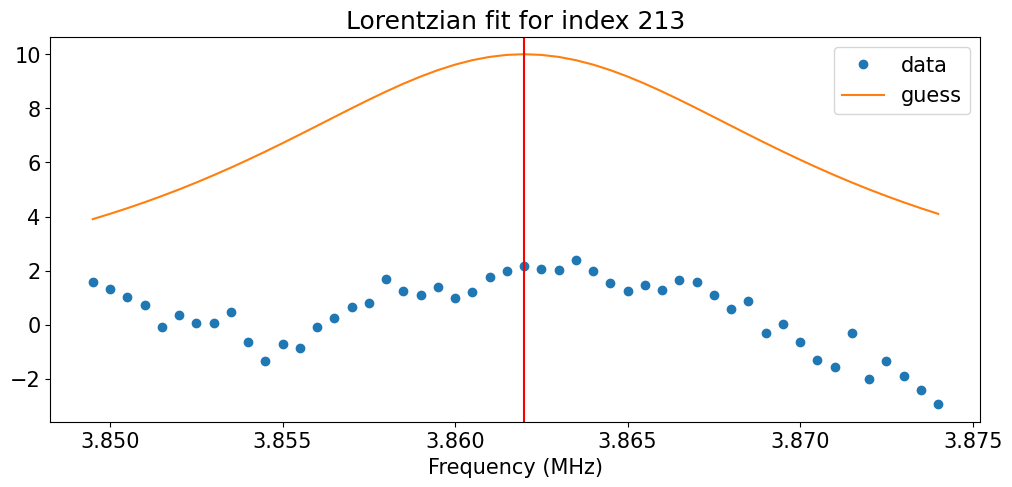

Couldn't get a fit


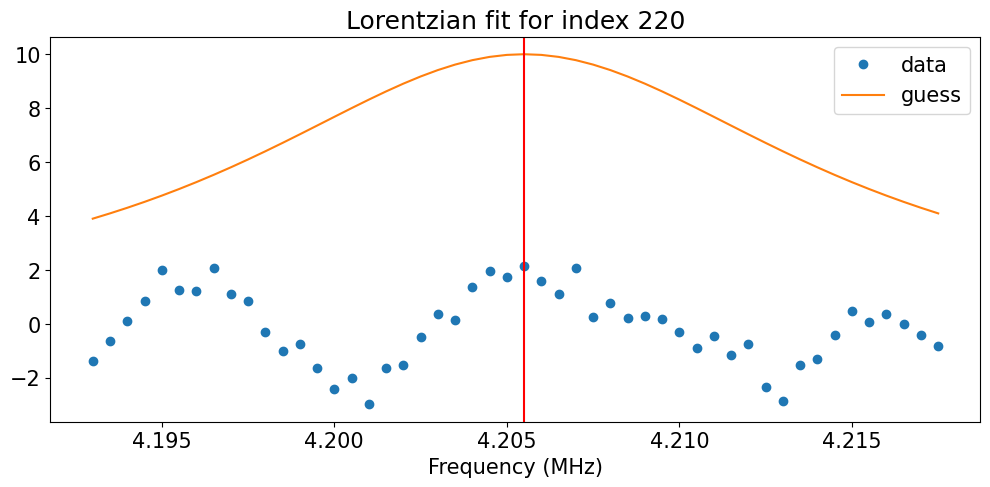

Couldn't get a fit


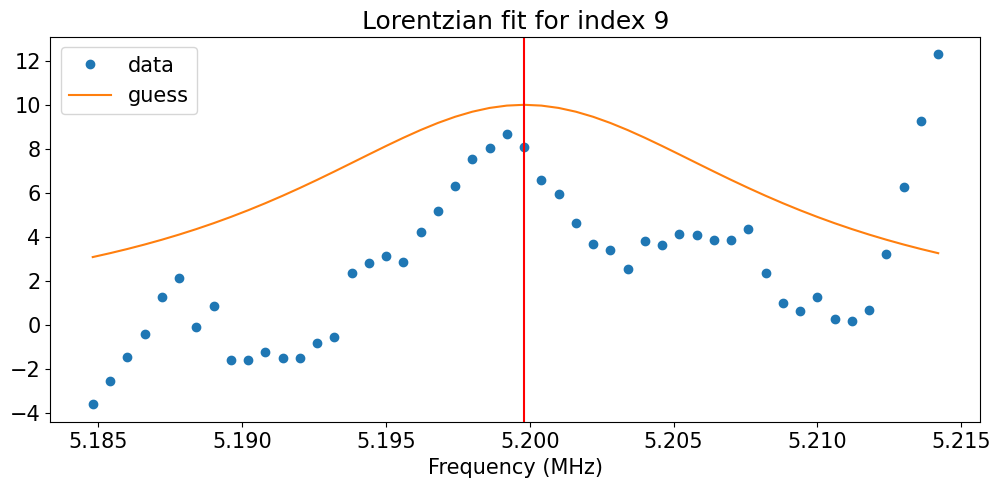

Couldn't get a fit


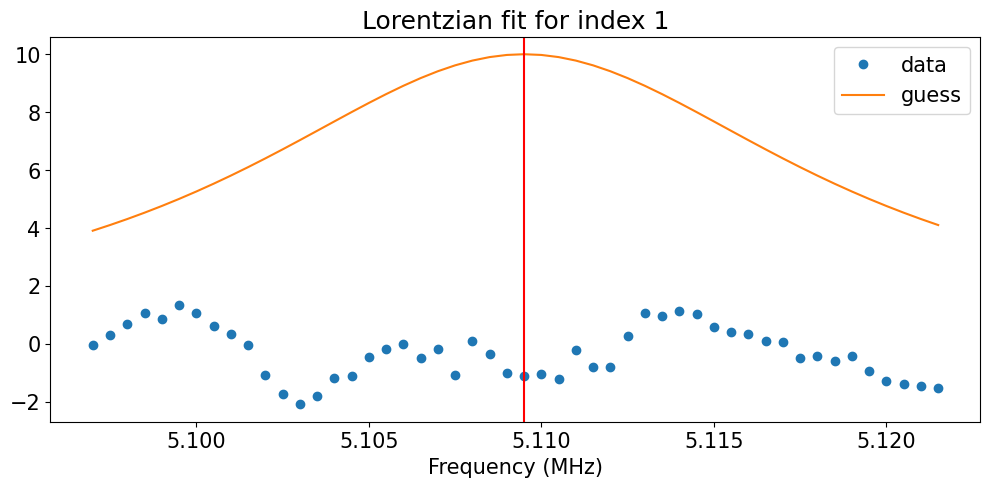

Couldn't get a fit


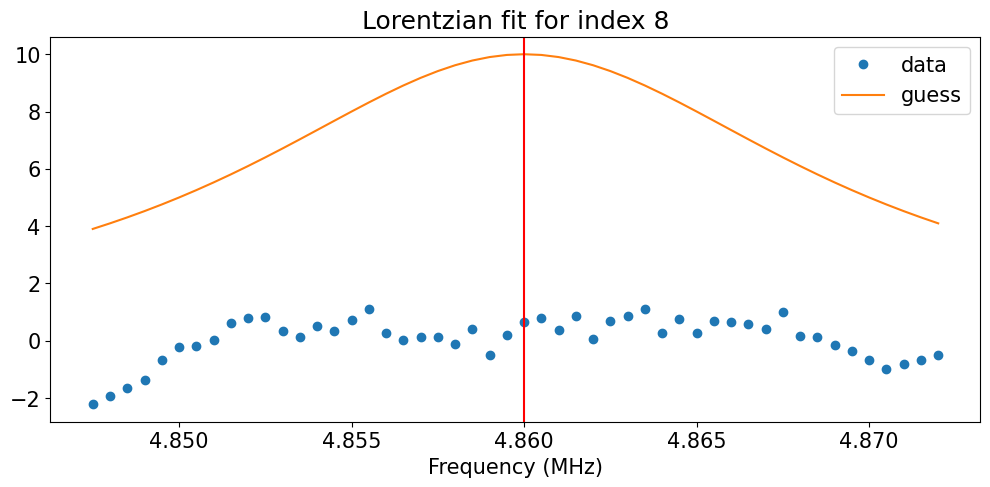

Couldn't get a fit


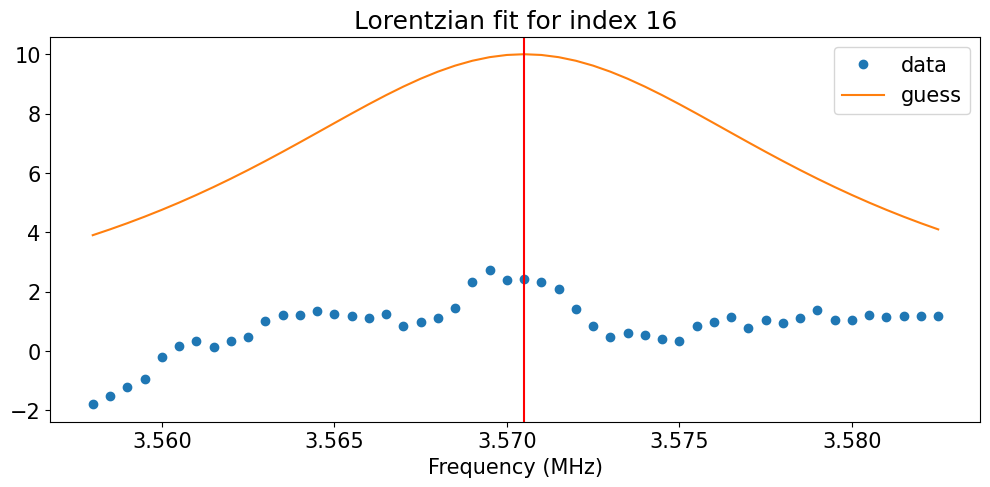

Couldn't get a fit


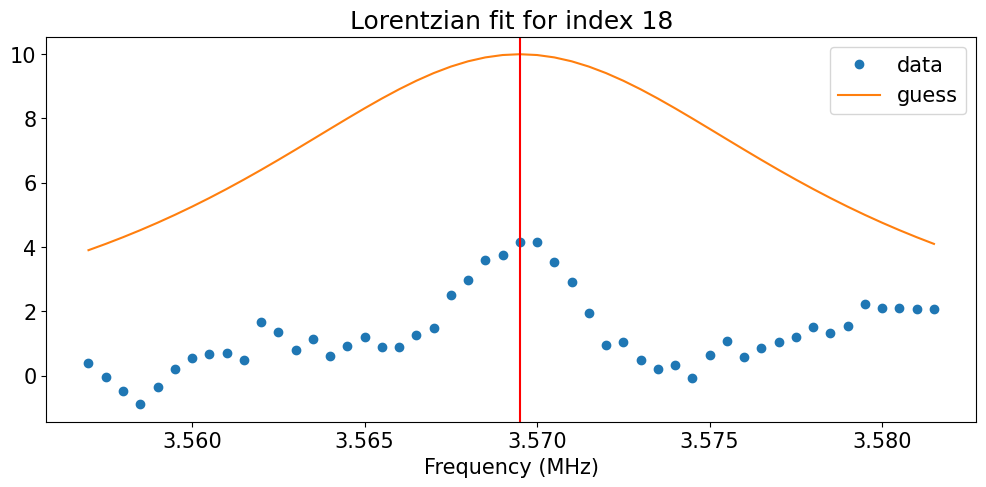

Couldn't get a fit


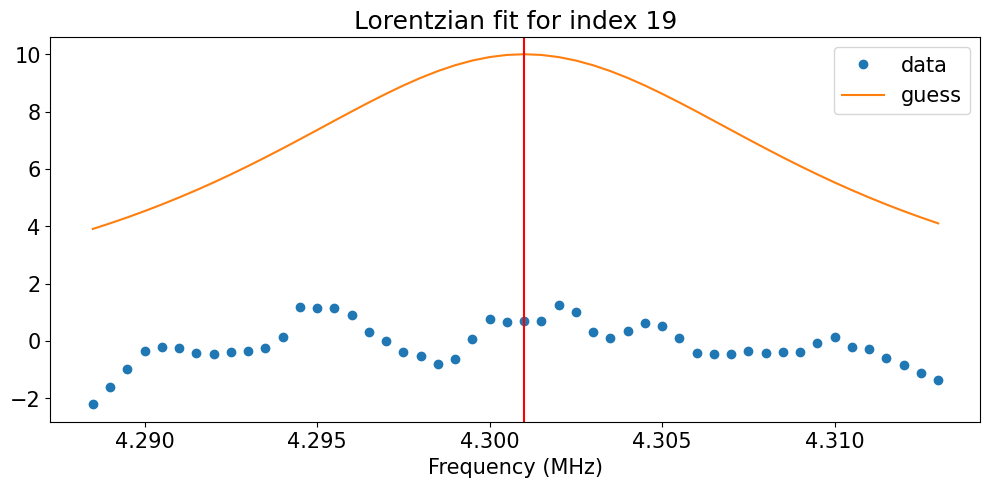

Couldn't get a fit


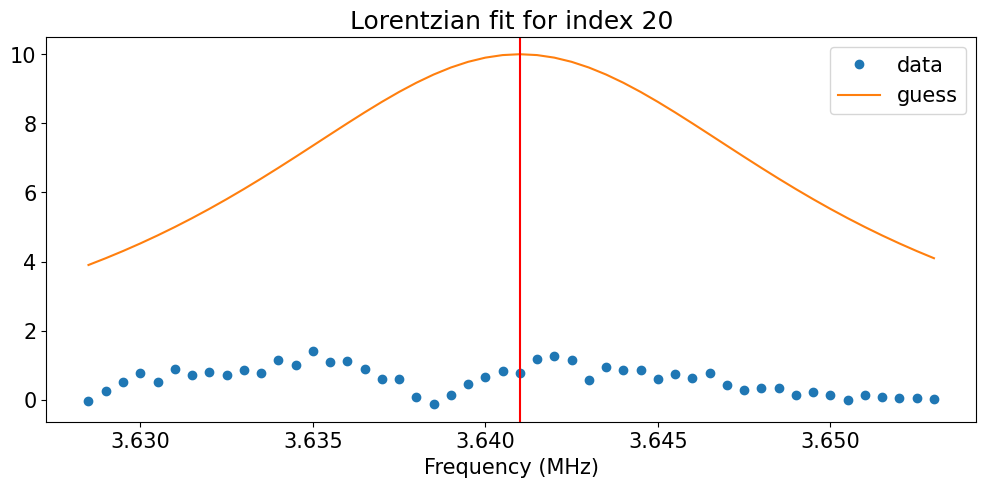

Couldn't get a fit


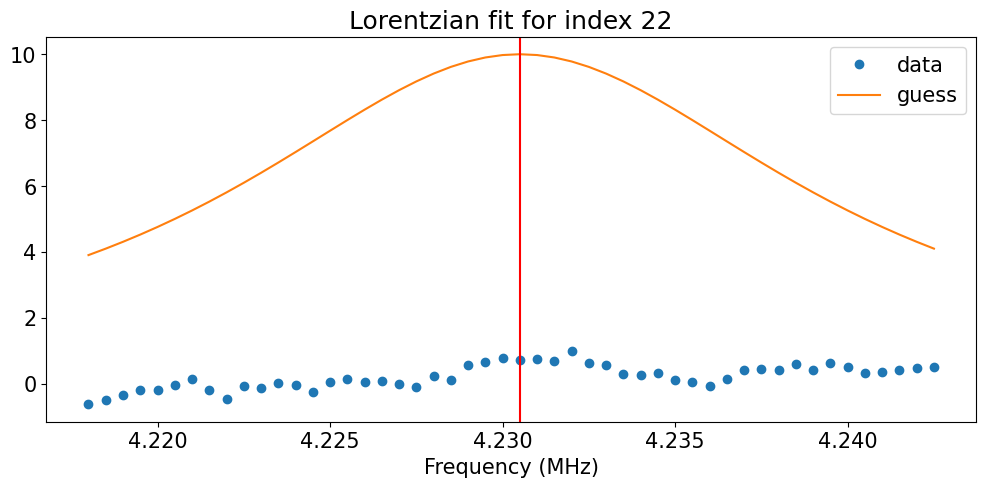

Couldn't get a fit


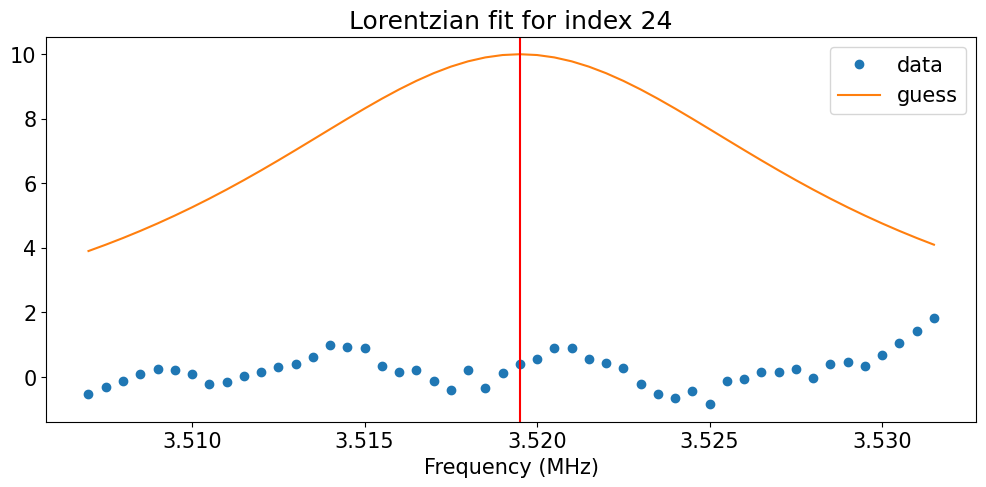

Couldn't get a fit


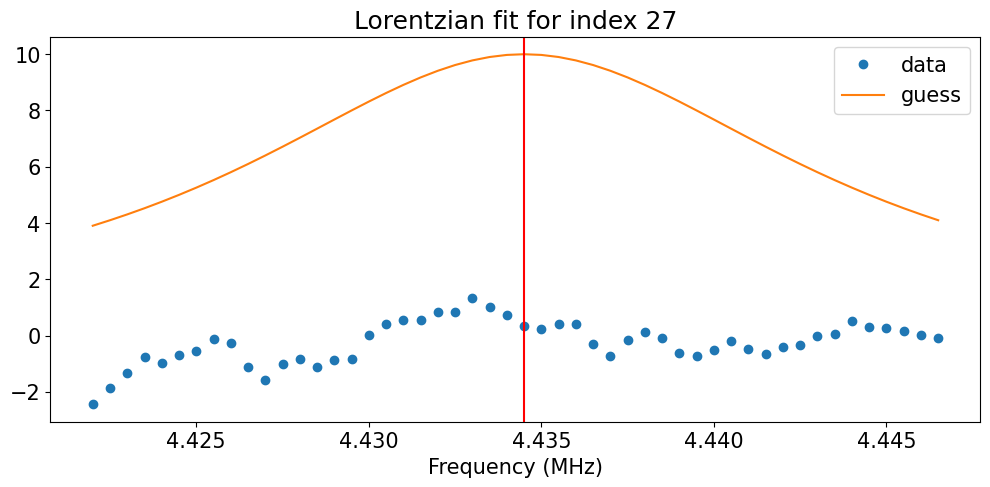

Couldn't get a fit


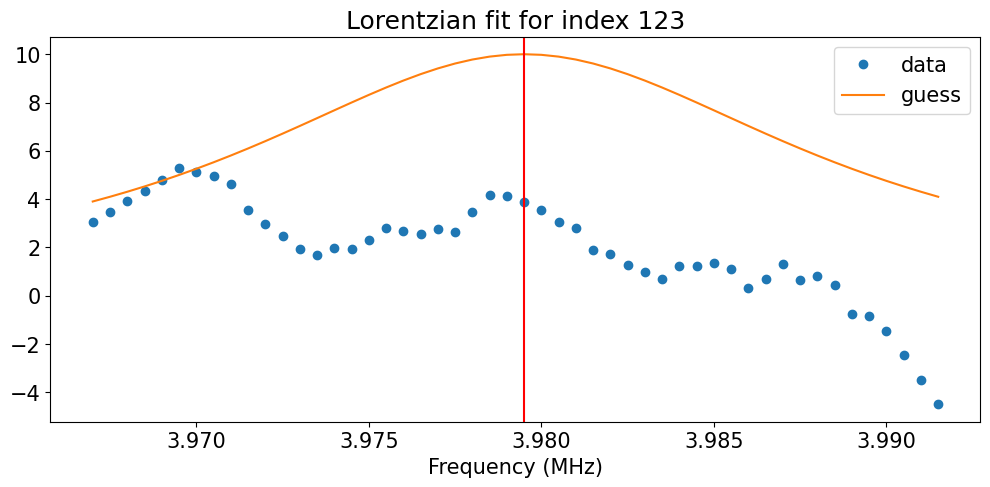

Couldn't get a fit


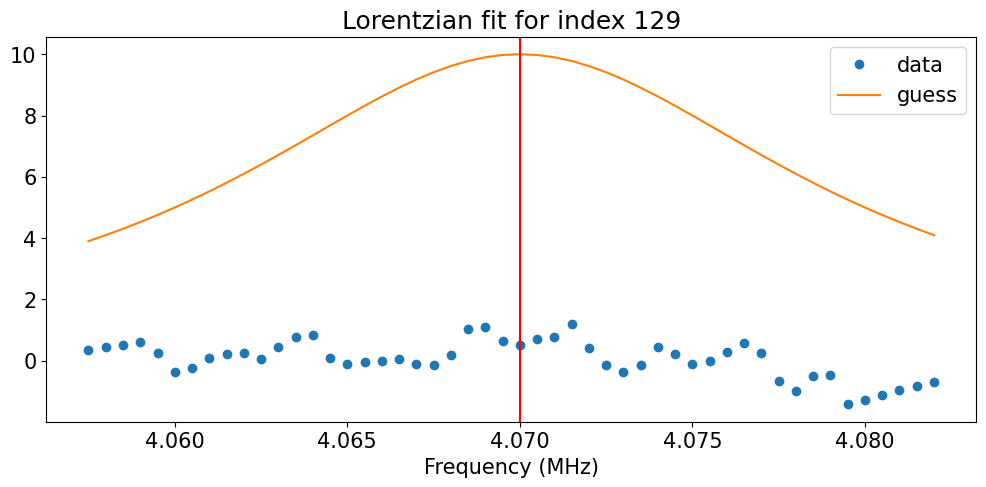

Couldn't get a fit


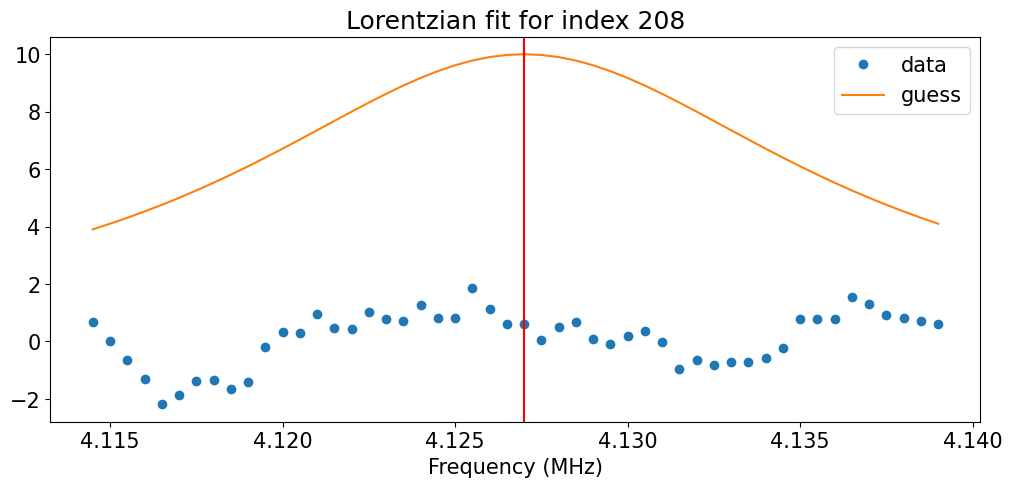

Couldn't get a fit


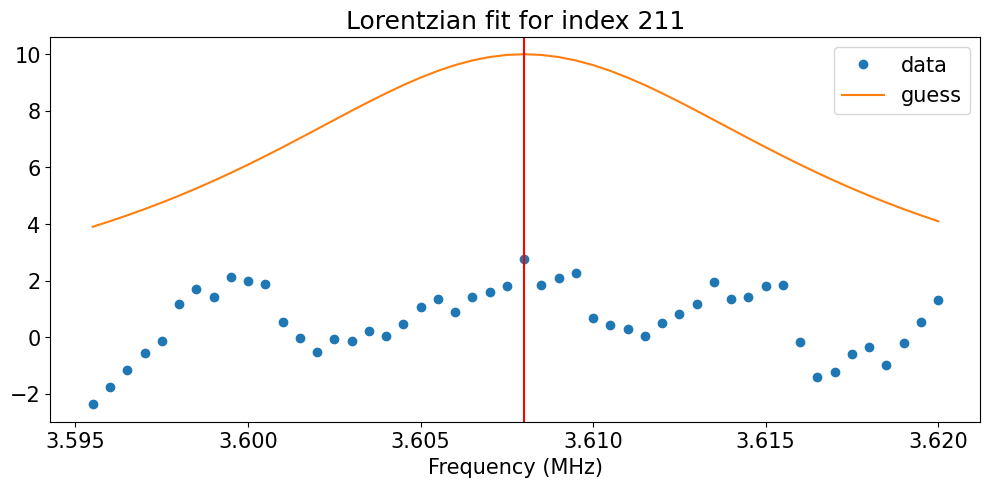

Couldn't get a fit


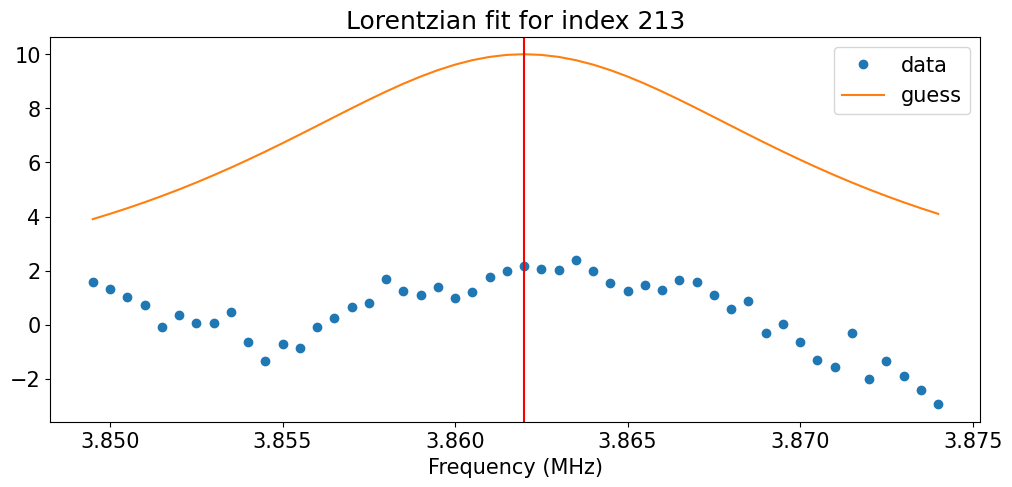

Couldn't get a fit


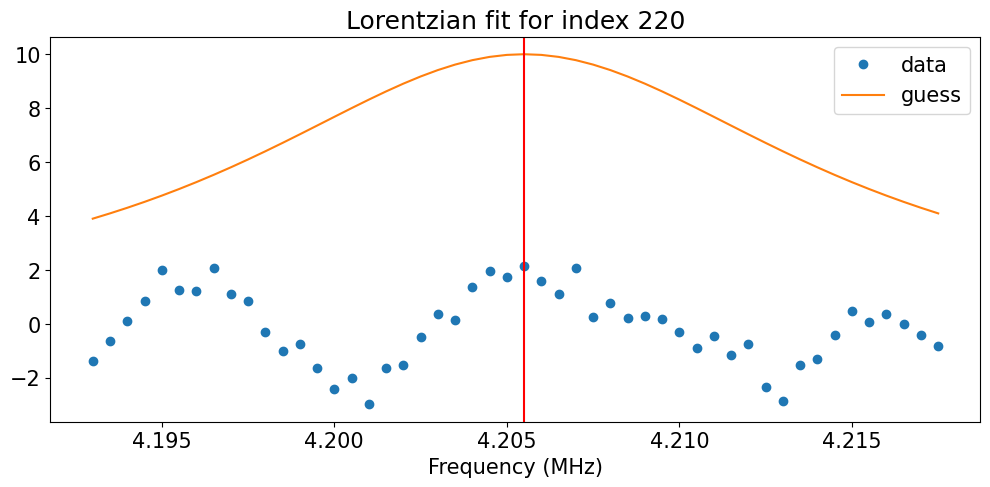

Couldn't get a fit


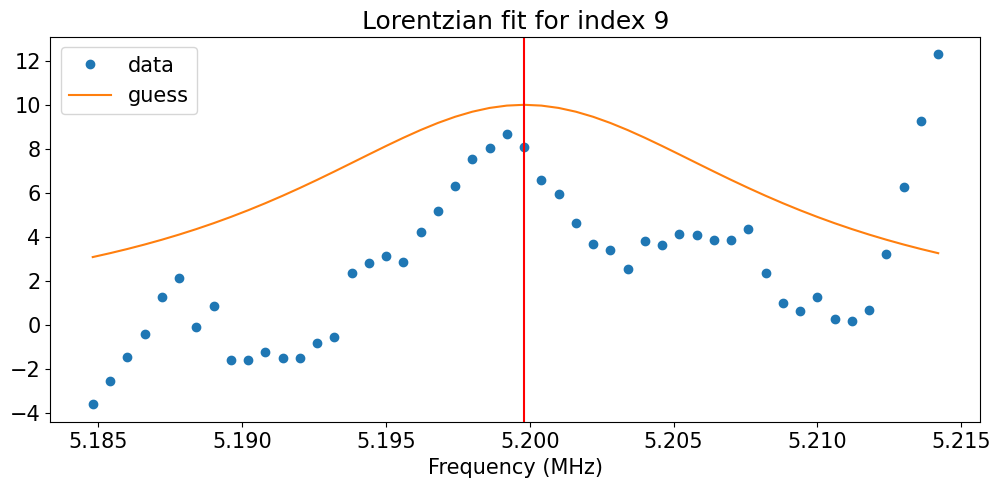

Couldn't get a fit


In [174]:
rescan_qubits = ['Q2', 'Q3', 'Q4']
# rescan_qubits = ['Q2']

for qubit in rescan_qubits:
    voltages = []
    center_frequencies = []
    center_frequency_errors = []

    plot_fits = False
    plot_as_flux=True
    plot_as_flux=False

#     for file in qubit_to_spec_filenames[qubit]:
        
    for file in test_filenames:

        voltage_data, frequency_data, transmission_data = get_data(file)
        start_index = 5
    #     filename = filepath.split('\\')[-1]
    #     if filename == filename4:
    #         start_index = [13, 1, 13, 9, 7, 5, 4, 1, 1, 1, 
    #                        1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    #                        1, 1, 2, 4, 8, 10, 12, 21, 14, 15,
    #                        17]
    #     elif filename == filename5:
    #         start_index = [1, 13, 9, 7, 4, 2, 1, 1, 1, 1, 
    #                        1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    #                        1, 2, 5, 7, 9, 12, 1, 13, 15, 17,
    #                        19]


        frequency_index_span = 50

    #     file_voltages, file_frequencies, error = get_center_frequencies(voltage_data, frequency_data, transmission_data, start_index, plot_fits=plot_fits, plot_center_frequencies=True, show_plot=False, plot_as_flux=plot_as_flux)
        file_voltages, file_frequencies, error = get_center_frequencies(voltage_data, frequency_data, transmission_data, start_index, frequency_index_span=frequency_index_span, plot_fits=plot_fits)

        voltages.extend(file_voltages)
        center_frequencies.extend(file_frequencies)
        center_frequency_errors.extend(error)

    voltages = np.array(voltages)
    center_frequencies = np.array(center_frequencies)
    center_frequency_errors = np.array(center_frequency_errors)

    plt.show()

    # sort data by voltage

    sorted_indices = voltages.argsort()
    voltages = voltages[sorted_indices]
    center_frequencies = center_frequencies[sorted_indices]
    center_frequency_errors = center_frequency_errors[sorted_indices]
    
    qubit_to_voltages[qubit] = voltages
    qubit_to_frequencies[qubit] = center_frequencies


### 2.2 Plot Results

In [18]:
### plot spec data with center frequencies
for qubit in qubits:
    voltage_data_all = qubit_to_voltage_data_all[qubit]
    frequency_data_all = qubit_to_frequency_data_all[qubit]
    transmission_data_all = qubit_to_transmission_data_all[qubit]
    
    if len(voltage_data_all) > 0:

        voltages = qubit_to_voltages[qubit]
        frequencies = qubit_to_frequencies[qubit]

        plot_spec_data(voltage_data_all, frequency_data_all, transmission_data_all, fit_voltages=voltages, fit_frequencies=frequencies, qubit_name=qubit)


KeyError: 'Q2'

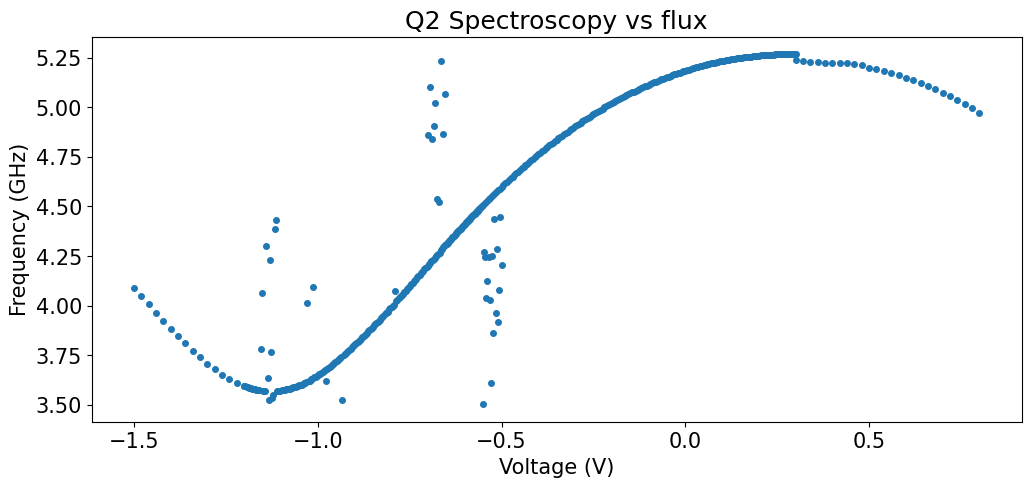

In [19]:
for qubit in qubits:
    if qubit in qubit_to_frequencies and qubit in qubit_to_voltages: 
        
        voltages = qubit_to_voltages[qubit]
        frequencies = qubit_to_frequencies[qubit]
        
        if len(frequencies) > 0:

            plt.plot(voltages, frequencies, marker='o', linestyle='', ms=4)

            plt.xlabel('Voltage (V)')
            plt.ylabel('Frequency (GHz)')

            plt.title(f'{qubit} Spectroscopy vs flux')

            plt.show()

### 2.3 Find points to ignore

In [20]:
qubit_to_filtered_voltages = {}
qubit_to_filtered_frequencies = {}

qubit_to_ignore_indices_expanded = {}

In [21]:
'''
define indices to ignore as list of indices
each element is an index or a tuple of index
if index, add that index to set of indices to ignore
if tuple (i1, i2), add the range [i1, i2) to the set of indices to ignore 
'''

qubit_to_ignore_indices = {}

qubit_to_ignore_indices['Q1'] = []

qubit_to_ignore_indices['Q2'] = [30, 31, (35, 40), 42, 43, 70, 75, 86, 100, 145, 174, 176, 179, 181, 184, 187, 189, 192, 194, 
                                 197, 250, 252, 254, 255, 257, 258, 260, 262, 263, 265, 267, 268, 270, 272, 273, 275, 276,
                                (437, 450)]

qubit_to_ignore_indices['Q3'] = [118, 158, 250, 267, 364, (386, 394)]

qubit_to_ignore_indices['Q4'] = [42, (151, 163), 166, 186, 221, 231, 256, 262, 270]


464
464
[30, 31, (35, 40), 42, 43, 70, 75, 86, 100, 145, 174, 176, 179, 181, 184, 187, 189, 192, 194, 197, 250, 252, 254, 255, 257, 258, 260, 262, 263, 265, 267, 268, 270, 272, 273, 275, 276, (437, 450)]
{257, 258, 260, 262, 263, 265, 267, 268, 270, 272, 145, 273, 275, 276, 30, 31, 35, 36, 37, 38, 39, 42, 43, 174, 176, 179, 181, 437, 438, 184, 439, 440, 187, 441, 189, 442, 443, 192, 444, 194, 445, 446, 197, 70, 447, 448, 449, 75, 86, 100, 250, 252, 254, 255}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 33, 34, 40, 41, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,

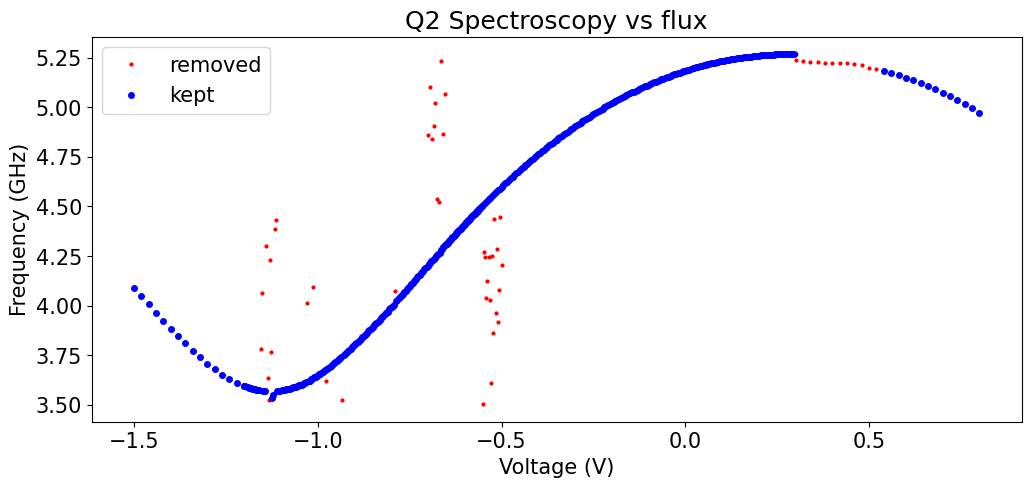

In [24]:
filter_qubits = ['Q2']
# filter_qubits = ['Q2', 'Q3', 'Q4']

for qubit in filter_qubits:
    if qubit in qubit_to_frequencies and qubit in qubit_to_voltages: 
        
        voltages = qubit_to_voltages[qubit]
        frequencies = qubit_to_frequencies[qubit]
        
        print(len(voltages))
        print(voltages)
        
        if len(frequencies) > 0:
            print(len(qubit_to_voltages[qubit]))
            
            ignore_indices = qubit_to_ignore_indices[qubit]
            
            print(ignore_indices)

            # expand tuple ranges into their explicit set of indices
            ignore_indices_expanded = set()

            for i in range(len(ignore_indices)):
                ignore_index = ignore_indices[i]
                if isinstance(ignore_index, int):
                    ignore_indices_expanded.add(ignore_index)
                elif isinstance(ignore_index, (tuple, list)):
                    ignore_indices_expanded.update(range(ignore_index[0], ignore_index[1]))
                    
            print(ignore_indices_expanded)

            inverse_ignore_indices = set(range(len(voltages))) - ignore_indices_expanded
            inverse_ignore_indices = list(inverse_ignore_indices)
            
            qubit_to_ignore_indices_expanded[qubit] = list(ignore_indices_expanded)
            
            qubit_to_filtered_voltages[qubit] = np.copy(voltages)[inverse_ignore_indices]
            qubit_to_filtered_frequencies[qubit] = np.copy(frequencies)[inverse_ignore_indices]
            
            print(inverse_ignore_indices)
            
            
            print(qubit_to_filtered_voltages[qubit])
            
            plt.plot(voltages[list(ignore_indices_expanded)], frequencies[list(ignore_indices_expanded)], marker='o', linestyle='', ms=2, color='red', label='removed')
            plt.plot(qubit_to_filtered_voltages[qubit], qubit_to_filtered_frequencies[qubit], marker='o', linestyle='', ms=4, color='blue', label='kept')
#             plt.plot(voltages, frequencies, alpha=0)

#             plt.xlim(1.15, 1.4)

            plt.xlabel('Voltage (V)')
            plt.ylabel('Frequency (GHz)')

            plt.legend()

            plt.title(f'{qubit} Spectroscopy vs flux')

            plt.show()           

# 3. Fit Spectrum to Model

### 3.1 Transmon Model

In [17]:
def frequency_model_fit(x, x0, a, b, c, d):
    return np.sqrt(a*np.sqrt(np.power(np.cos(b*(x-x0)),2) + (d**2)*np.power(np.sin(b*(x-x0)),2))) - c

In [18]:
# initial guesses
qubit_to_transmon_initial_guess = {}

qubit_to_transmon_initial_guess['Q2'] = [-0.5, 30, 1.2, 0.2, 0.6]
qubit_to_transmon_initial_guess['Q3'] = [-0.5, 30, 1.2, 0.2, 0.6]
qubit_to_transmon_initial_guess['Q4'] = [-0.5, 30, 1.2, 0.2, 0.6]

# bounds
qubit_to_transmon_bounds = {}

qubit_to_transmon_bounds['Q2'] = ((-np.inf, 0, 0, 0.199, 0), (np.inf, np.inf, np.inf, 0.202, 1))
qubit_to_transmon_bounds['Q3'] = ((-np.inf, 0, 0, 0.199, 0), (np.inf, np.inf, np.inf, 0.202, 1))
qubit_to_transmon_bounds['Q4'] = ((-np.inf, 0, 0, 0.199, 0), (np.inf, np.inf, np.inf, 0.202, 1))


In [19]:
# transmon popts, pcovs
qubit_to_transmon_popts = {}
qubit_to_transmon_pcovs = {}

[ 0.24319931 30.12476583  1.12756666  0.199       0.47494391]


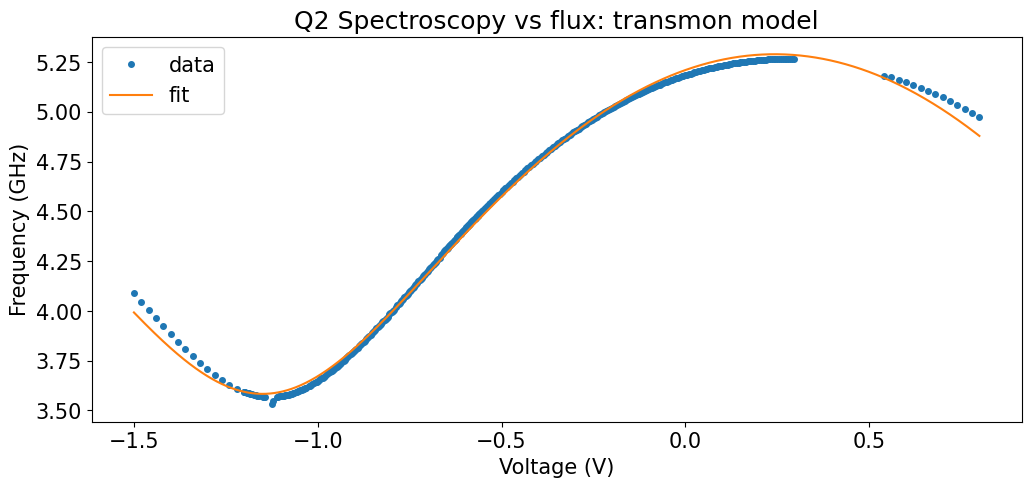

[-0.37206575 31.54499497  1.15220421  0.199       0.46712212]


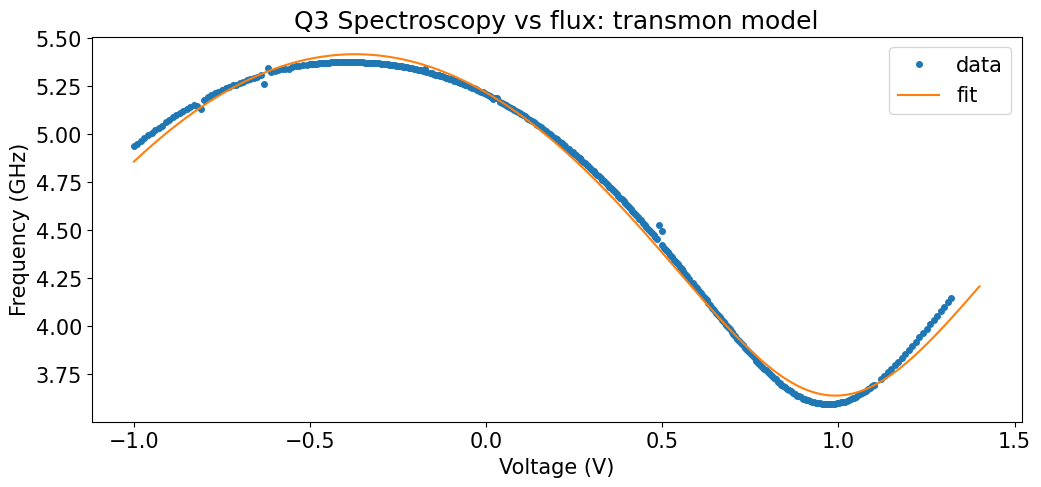

[7.05958572e-03 3.37957709e+01 1.19117465e+00 1.99000000e-01
 3.30542358e-01]


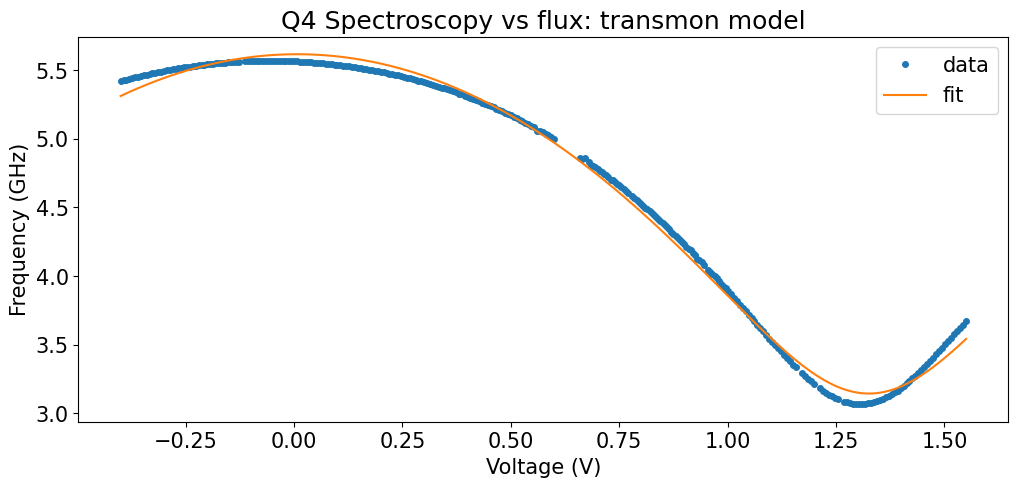

In [20]:
spec_fit_qubits = ['Q2', 'Q3', 'Q4']
# spec_fit_qubits = ['Q2']
show_guess = False

for qubit in spec_fit_qubits:
    transmon_initial_guess = qubit_to_transmon_initial_guess[qubit]
    transmon_bounds = qubit_to_transmon_bounds[qubit]
    
    voltages = qubit_to_voltages[qubit]
    
    filtered_voltages = qubit_to_filtered_voltages[qubit]
    filtered_frequencies = qubit_to_filtered_frequencies[qubit]

    fit_voltages = np.linspace(voltages[0], voltages[-1], 1001)
    
    plt.plot(filtered_voltages, filtered_frequencies, marker='o', linestyle='', ms=4, label='data')
    
    if show_guess:
        plt.plot(fit_voltages, frequency_model_fit(fit_voltages, *transmon_initial_guess), label='guess')
    
    # fit
    transmon_popt, transmon_pcov = curve_fit(frequency_model_fit, filtered_voltages, filtered_frequencies, p0=transmon_initial_guess, bounds=transmon_bounds)
    print(transmon_popt)
    
    qubit_to_transmon_popts[qubit] = transmon_popt
    qubit_to_transmon_pcovs[qubit] = transmon_pcov

    plt.plot(fit_voltages, frequency_model_fit(fit_voltages, *transmon_popt), label='fit')
    
    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (GHz)')

    plt.title(f'{qubit} Spectroscopy vs flux: transmon model')

    plt.legend()

    plt.show()

### 3.2 Trianglemon Model

In [21]:
def frequency_model_fit_trianglemon(x, x0, a, b, c, d, e):
    
    EJ = np.sqrt(np.power(np.cos(b*(x-x0)),2) + (d**2)*np.power(np.sin(b*(x-x0)),2))
    
    return np.sqrt(a*EJ/(1+e*EJ)) - c/np.power(1+e*EJ, 3)

In [22]:
# initial guesses
qubit_to_trianglemon_initial_guess = {}

qubit_to_trianglemon_initial_guess['Q2'] = list(qubit_to_transmon_initial_guess['Q2']) + [0.1]
qubit_to_trianglemon_initial_guess['Q2'][3] = 0.2006

qubit_to_trianglemon_initial_guess['Q3'] = list(qubit_to_transmon_initial_guess['Q3']) + [0.1]
qubit_to_trianglemon_initial_guess['Q3'][3] = 0.2004

qubit_to_trianglemon_initial_guess['Q4'] = list(qubit_to_transmon_initial_guess['Q4']) + [0.1]
qubit_to_trianglemon_initial_guess['Q4'][3] = 0.2002

# bounds
qubit_to_trianglemon_bounds = {}

qubit_to_trianglemon_bounds['Q2'] = ((-np.inf, 0, 0, 0.2005, 0, 0), (np.inf, np.inf, np.inf, 0.2006, 1, np.inf))
qubit_to_trianglemon_bounds['Q3'] = ((-np.inf, 0, 0, 0.2004, 0, 0), (np.inf, np.inf, np.inf, 0.2005, 1, np.inf))
qubit_to_trianglemon_bounds['Q4'] = ((-np.inf, 0, 0, 0.2002, 0, 0), (np.inf, np.inf, np.inf, 0.2003, 1, np.inf))



In [23]:
# transmon popts, pcovs
qubit_to_trianglemon_popts = {}
qubit_to_trianglemon_err = {}


Q2:
	x0 = -2.53 +- 0.0007679990686687285
	a = 38.072 +- 0.9202011356353401
	b = 1.12 +- 0.0004931124972075487
	c = 0.201 +- 0.06815313202812882
	d = 0.408 +- 0.0030615575178914297
	e = 0.328 +- 0.019738823204690448


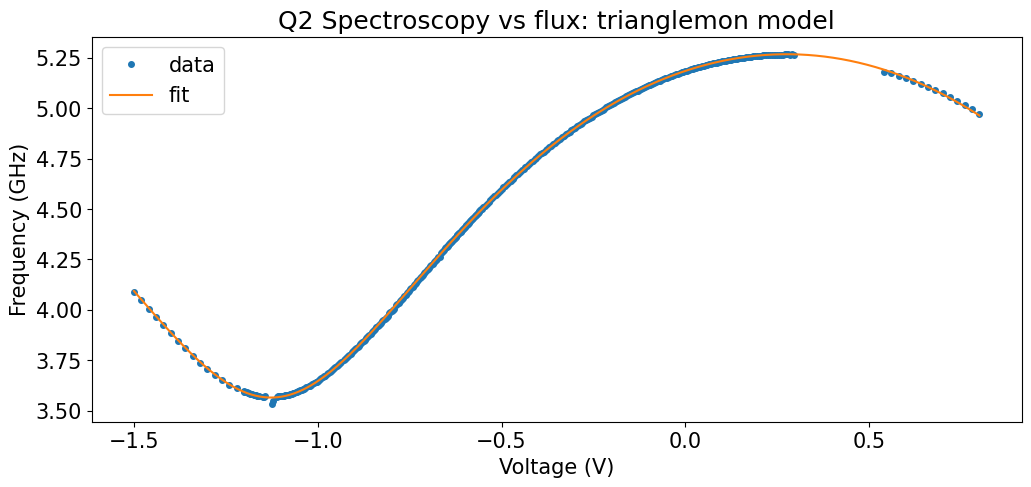

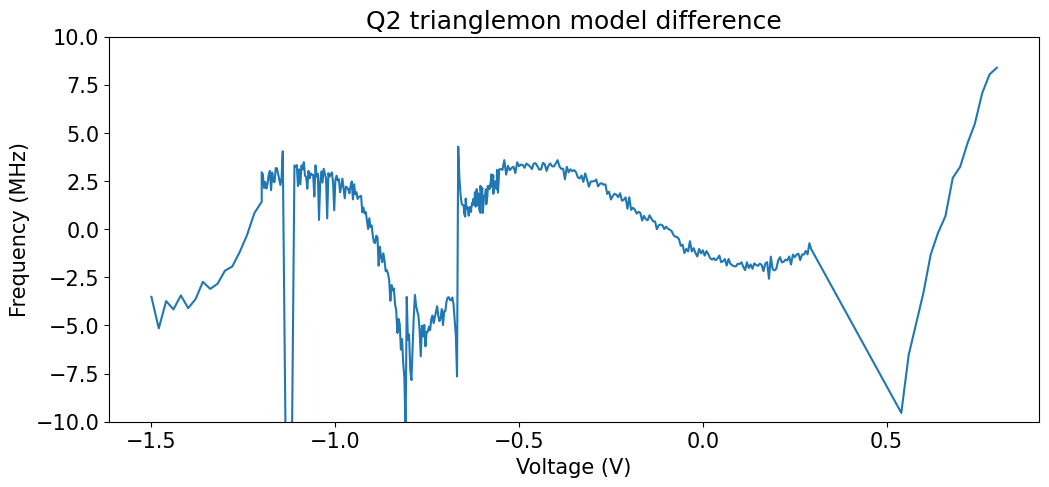

Q3:
	x0 = -0.387 +- 0.0006359496924435051
	a = 41.815 +- 1.6713540502433901
	b = 1.158 +- 0.0006534401372934047
	c = 0.2 +- 0.12382038763772941
	d = 0.383 +- 0.00564121200133372
	e = 0.407 +- 0.03645781039412429


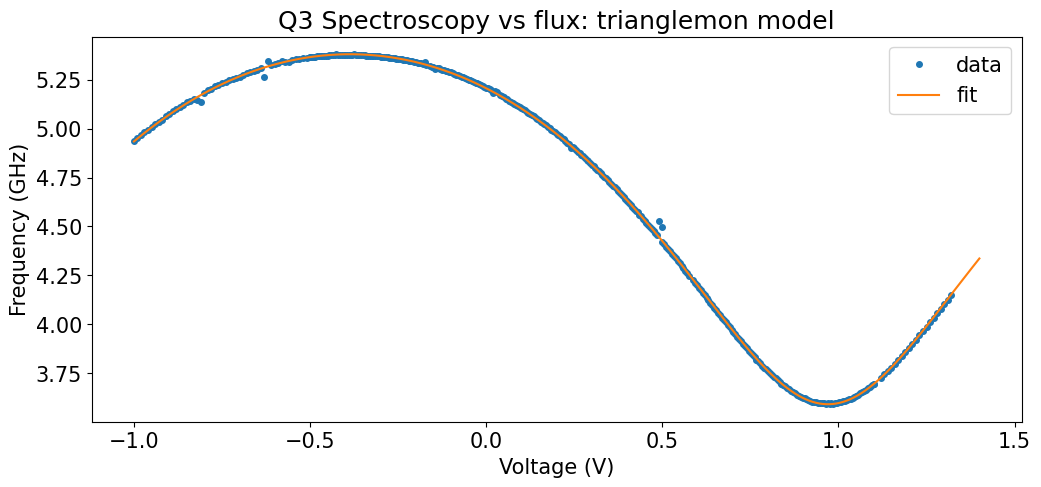

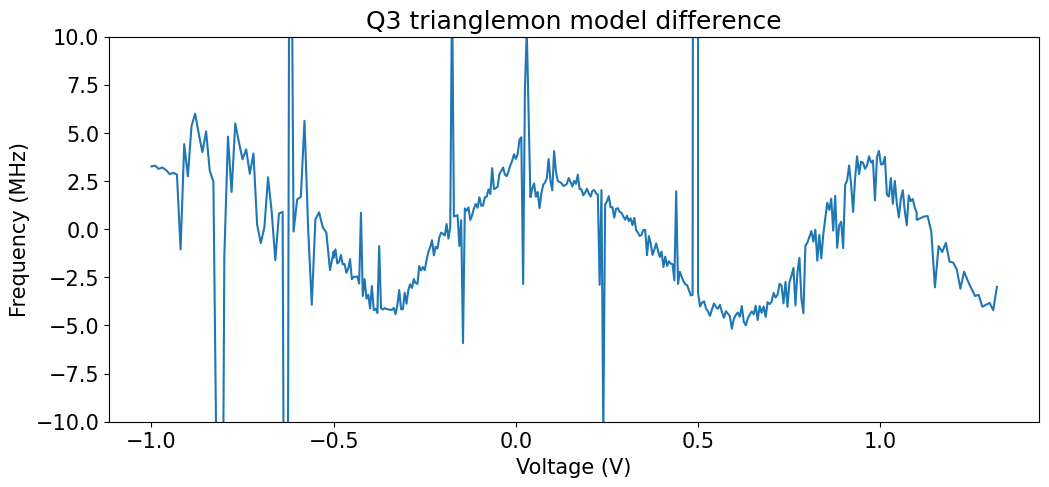

Q4:
	x0 = -0.051 +- 0.0006250009983903465
	a = 45.44 +- 0.4758720192226412
	b = 1.158 +- 0.0005445059099144192
	c = 0.2 +- 0.02902802416994774
	d = 0.251 +- 0.0013730759058518764
	e = 0.429 +- 0.010891694374735443


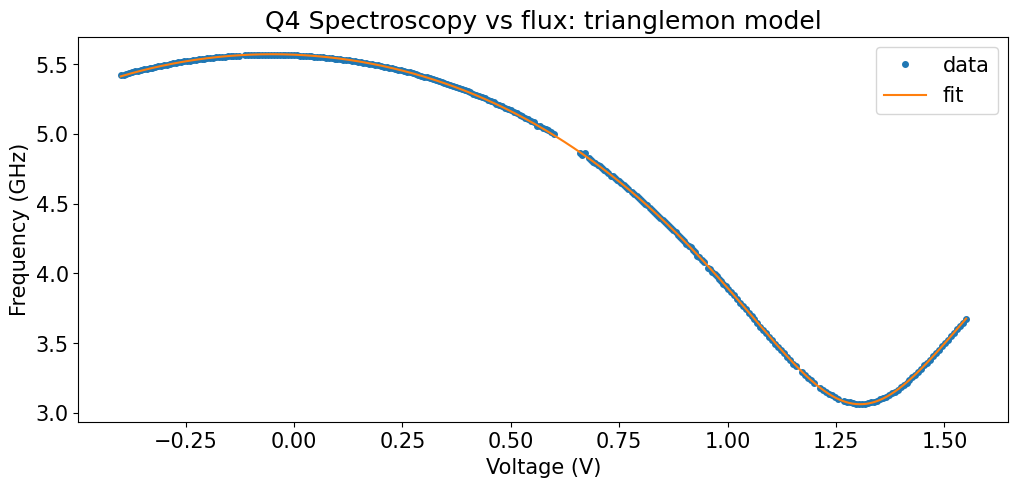

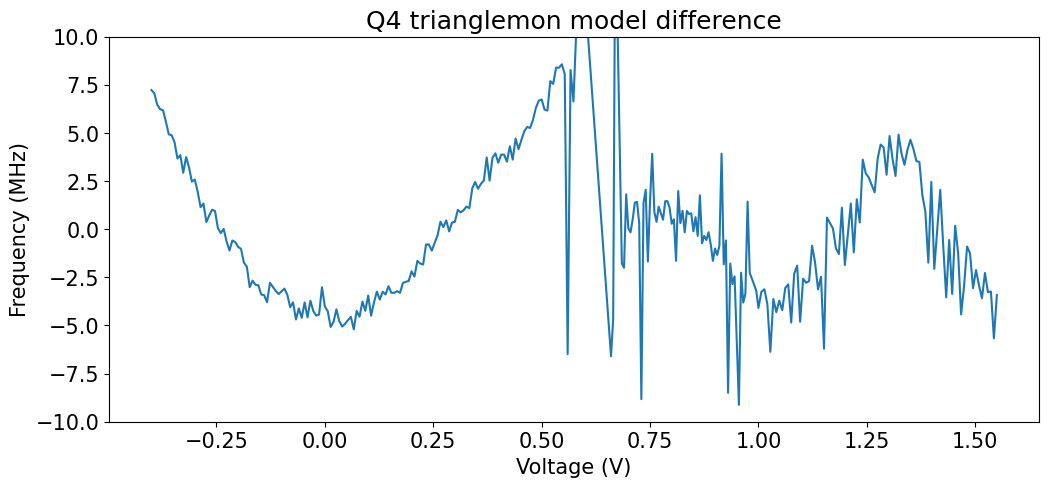

In [24]:
spec_fit_qubits = ['Q2', 'Q3', 'Q4']
# spec_fit_qubits = ['Q2']
show_guess = False

for qubit in spec_fit_qubits:
    trianglemon_initial_guess = qubit_to_trianglemon_initial_guess[qubit]
    trianglemon_bounds = qubit_to_trianglemon_bounds[qubit]
    
    voltages = qubit_to_voltages[qubit]
    frequencies = qubit_to_frequencies[qubit]
    
    filtered_voltages = qubit_to_filtered_voltages[qubit]
    filtered_frequencies = qubit_to_filtered_frequencies[qubit]
    
    
    fit_voltages = np.linspace(voltages[0], voltages[-1], 1001)
    
    plt.plot(filtered_voltages, filtered_frequencies, marker='o', linestyle='', ms=4, label='data')
    
    if show_guess:
        plt.plot(fit_voltages, frequency_model_fit_trianglemon(fit_voltages, *trianglemon_initial_guess), label='guess')

    # fit
    trianglemon_popt, trianglemon_pcov = curve_fit(frequency_model_fit_trianglemon, filtered_voltages, filtered_frequencies, p0=trianglemon_initial_guess, bounds=trianglemon_bounds)
    
    qubit_to_trianglemon_popts[qubit] = trianglemon_popt

    plt.plot(fit_voltages, frequency_model_fit_trianglemon(fit_voltages, *trianglemon_popt), label='fit')
    
    # fit parameters
    trianglemon_err = np.sqrt(np.diag(trianglemon_pcov))
    qubit_to_trianglemon_err[qubit] = trianglemon_err

    fit_param_names = ['x0', 'a', 'b', 'c', 'd', 'e']

    print(f'{qubit}:')
    for i in range(len(fit_param_names)):
        print(f'\t{fit_param_names[i]} = {round(trianglemon_popt[i], 3)} +- {trianglemon_err[i]}')
        
    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (GHz)')

    plt.title(f'{qubit} Spectroscopy vs flux: trianglemon model')

    plt.legend()

    plt.show()
    
    ### plot difference
    
    plt.plot(filtered_voltages, (filtered_frequencies - frequency_model_fit_trianglemon(filtered_voltages, *trianglemon_popt))*1000)
    
    
    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (MHz)')

    plt.title(f'{qubit} trianglemon model difference')
    
    plt.ylim(-10, 10)


    plt.show()

### 3.3 Extract parameters

$$\omega = 2\pi\sqrt{\frac{8 E_c E_J}{1+\frac{L_g}{L_J}}} - 2\pi\frac{E_c}{\left(1+\frac{L_g}{L_J}\right)^3}$$

$$L_J = \frac{\Phi_0^2}{(2\pi)^2E_J}$$

$$E_J = E_{J\text{max}}\sqrt{\cos^2{\left(\frac{\pi\Phi}{\Phi_0}\right)} + d^2\sin^2{\left(\frac{\pi\Phi}{\Phi_0}\right)}}$$

$$E_{J\text{max}} = E_{J1} + E_{J2}$$

$$d = \frac{E_{J2} - E_{J1}}{E_{J2} + E_{J1}}$$



Phase is current times mutual inductance
$$\Phi = MI$$ 

Relate to voltage
$$\Phi = \frac{MV}{R}$$ 

Flux quantum
$$\Phi_0 = \frac{h}{2e}$$

Rewrite
$$\omega = 2\pi\sqrt{\frac{8 E_c E_J}{1+\frac{L_g(2\pi)^2E_J}{\Phi_0^2}}} - \frac{E_c}{\left(1+\frac{L_g(2\pi)^2E_J}{\Phi_0^2}\right)^3}$$


$$\omega = 2\pi\sqrt{\frac{8 E_c E_{J\text{max}}\sqrt{\cos^2{\left(\frac{\pi MV}{\Phi_0R}\right)} + d^2\sin^2{\left(\frac{\pi MV}{\Phi_0R}\right)}}}{1+\frac{L_g(2\pi)^2E_{J\text{max}}\sqrt{\cos^2{\left(\frac{\pi MV}{\Phi_0R}\right)} + d^2\sin^2{\left(\frac{\pi MV}{\Phi_0R}\right)}}}{\Phi_0^2}}} - \frac{E_c}{\left(1+\frac{L_g(2\pi)^2E_{J\text{max}}\sqrt{\cos^2{\left(\frac{\pi MV}{\Phi_0R}\right)} + d^2\sin^2{\left(\frac{\pi MV}{\Phi_0R}\right)}}}{\Phi_0^2}\right)^3}$$

$$\omega = 2\pi\sqrt{\frac{a\sqrt{\cos^2{\left(b(V-x_0)\right)} + d^2\sin^2{\left(b(V-x_0)\right)}}}{1+e_1\sqrt{\cos^2{\left(b(V-x_0)\right)} + d^2\sin^2{\left(b(V-x_0)\right)}}}} - \frac{c}{\left(1+e_1\sqrt{\cos^2{\left(b(V-x_0)\right)} + d^2\sin^2{\left(b(V-x_0)\right)}}\right)^3}$$

$$a = 8E_cE_{J\text{max}}$$

$$b = \frac{\pi M}{\Phi_0 R}$$

$$c = E_c$$

$$e_1 = \frac{L_g (2\pi)^2E_{J\text{max}}}{\Phi_0^2}$$

In [25]:
# define constants

h = 6.626e-34
hbar = h/(2*np.pi)
e = 1.6e-19 # Coulombs

Phi_0 = h/(2*e)


In [26]:
extract_param_qubits = ['Q2', 'Q3','Q4']
# extract_param_qubits = ['Q2']

qubit_to_Ec = {}
qubit_to_E_J_1 = {}
qubit_to_E_J_2 = {}
qubit_to_L_g = {}
qubit_to_L_g_err = {}

for qubit in extract_param_qubits:
    
    trianglemon_popt = qubit_to_trianglemon_popts[qubit]
    trianglemon_err = qubit_to_trianglemon_err[qubit]
    
    x0, a, b, c, d, e_1 = trianglemon_popt
    x0_err, a_err, b_err, c_err, d_err, e_1_err = trianglemon_err

    # x0 is phase offset
    # b has information about the mutual inductance and resistance of the fluxline
    # c has information about Ec
    # d has information aobut the percent difference between E_J1 and E_J2
    # e has information about the ratio of L_g to L_J

    print(f'{qubit}:')
    
    E_c = c
    qubit_to_Ec[qubit] = E_c
    print(f'\tE_c = {E_c*1e3} MHz')
    
    E_J_max = a/(8*E_c)
    print(f'\tE_J_max = {E_J_max} GHz')

    # EJ2 - EJ1 = d*E_J_max
    E_J_2 = (d+1)*E_J_max/2
    E_J_1 = (1-d)*E_J_max/2

    print(f'\tE_J_1 = {E_J_1} GHz')
    print(f'\tE_J_2 = {E_J_2} GHz')

    qubit_to_E_J_1[qubit] = E_J_1
    qubit_to_E_J_2[qubit] = E_J_2
    
    
    L_g = e_1*(Phi_0/(2*np.pi))**2/E_J_max/h
    L_g_err = e_1_err*(Phi_0/(2*np.pi))**2/E_J_max/h

    print(f'\n\tL_g = {round(L_g, 3)} nH +- {round(L_g_err, 3)} nH')
    print()
    
    qubit_to_L_g = L_g
    qubit_to_L_g_err = L_g_err



Q2:
	E_c = 200.59999999999997 MHz
	E_J_max = 23.723708204502014 GHz
	E_J_1 = 7.018987488481753 GHz
	E_J_2 = 16.70472071602026 GHz

	L_g = 2.268 nH +- 0.136 nH

Q3:
	E_c = 200.49999999999997 MHz
	E_J_max = 26.069115972406355 GHz
	E_J_1 = 8.044594323386535 GHz
	E_J_2 = 18.024521649019817 GHz

	L_g = 2.557 nH +- 0.229 nH

Q4:
	E_c = 200.29999999999998 MHz
	E_J_max = 28.357315682214242 GHz
	E_J_1 = 10.61921819392876 GHz
	E_J_2 = 17.73809748828548 GHz

	L_g = 2.479 nH +- 0.063 nH



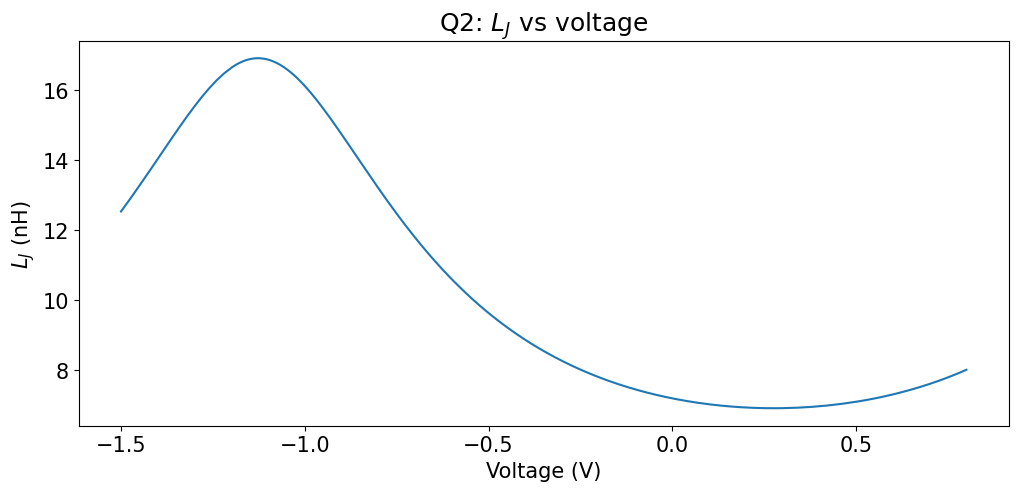

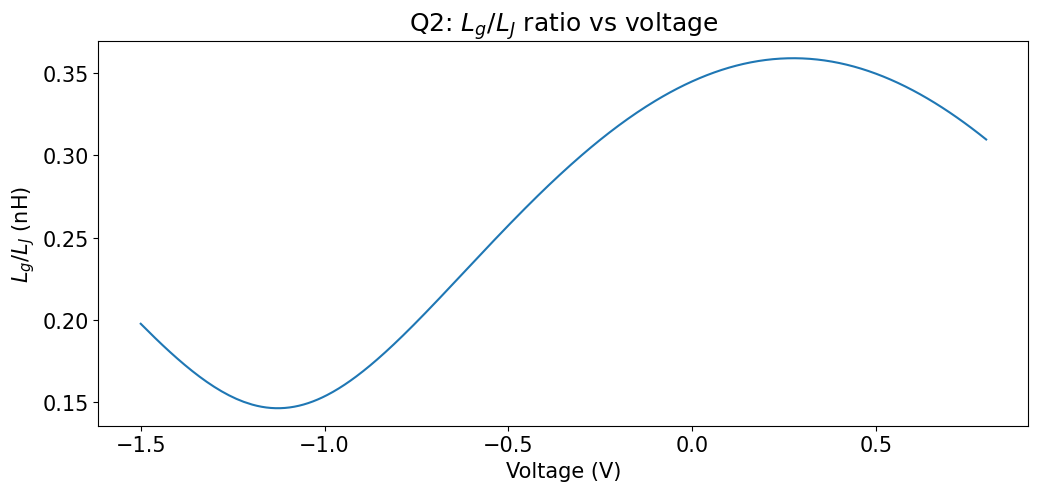

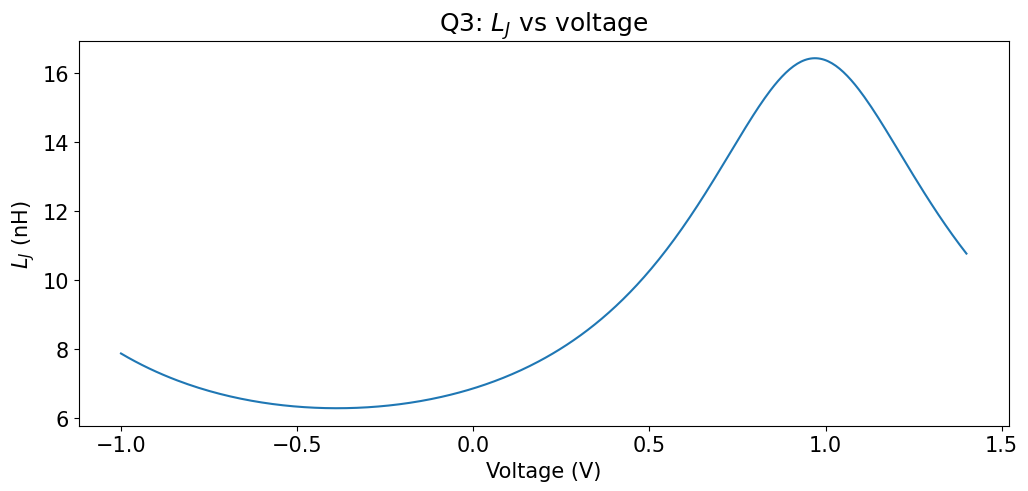

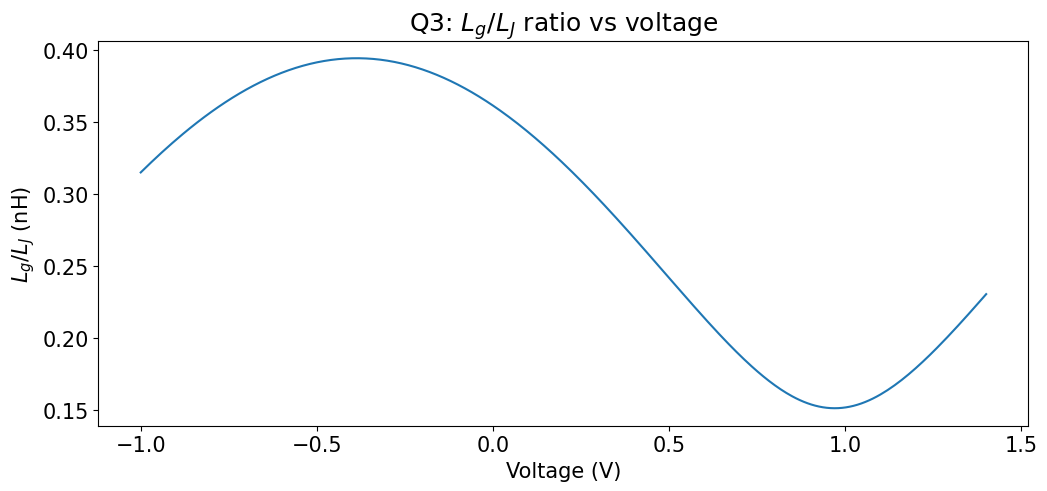

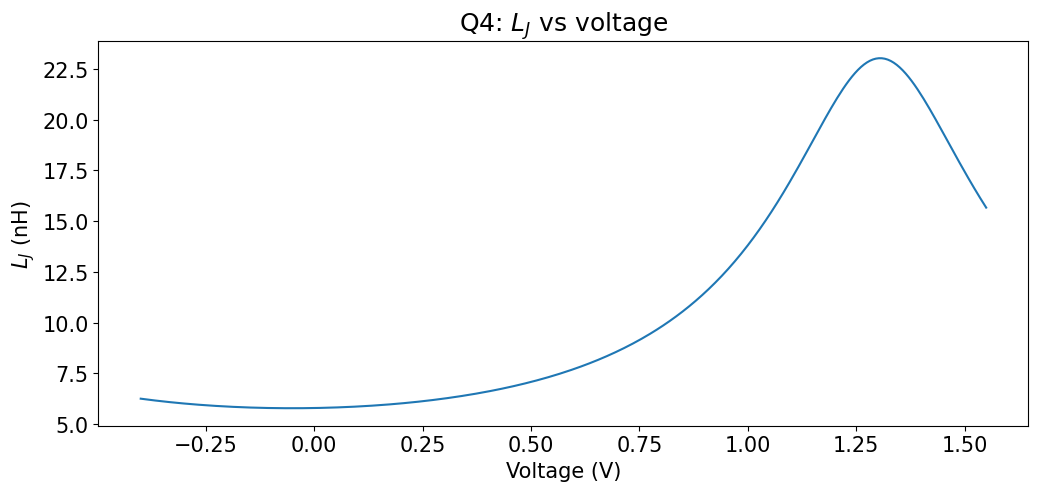

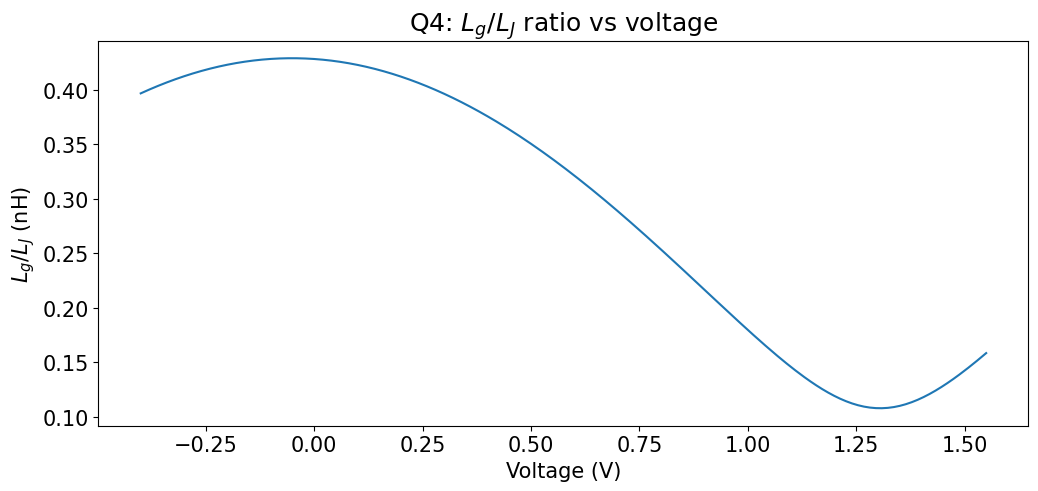

In [27]:
### plot LJ vs voltage
for qubit in extract_param_qubits:
    
    trianglemon_popt = qubit_to_trianglemon_popts[qubit]
    trianglemon_err = qubit_to_trianglemon_err[qubit]
    
    voltages = qubit_to_voltages[qubit]
    
    x0, a, b, c, d, e_1 = trianglemon_popt
    
    E_J_1 = qubit_to_E_J_1[qubit]
    E_J_2 = qubit_to_E_J_2[qubit]
    E_J_max = E_J_1 + E_J_2
    
    E_J = lambda V: E_J_max*np.sqrt(np.power(np.cos(b*(V-x0)),2) + (d**2)*np.power(np.sin(b*(V-x0)),2))
    L_J = lambda V: (Phi_0/(2*np.pi))**2/E_J(V)/h

    plt.plot(voltages, L_J(voltages))

    plt.xlabel('Voltage (V)')
    plt.ylabel('$L_J$ (nH)')

    plt.title(f'{qubit}: $L_J$ vs voltage')
    plt.show()

    plt.plot(voltages, L_g/L_J(voltages))

    plt.xlabel('Voltage (V)')
    plt.ylabel('$L_g$/$L_J$ (nH)')

    plt.title(f'{qubit}: $L_g$/$L_J$ ratio vs voltage')
    plt.show()

In [28]:
### flux quantum / voltage period factor


for qubit in extract_param_qubits:
    
    trianglemon_popt = qubit_to_trianglemon_popts[qubit]
    trianglemon_err = qubit_to_trianglemon_err[qubit]
    
    x0, a, b, c, d, e_1 = trianglemon_popt
    x0_err, a_err, b_err, c_err, d_err, e_1_err = trianglemon_err
    
    print(f'{qubit} voltage period: {round(np.pi/b, 3)} V')

Q2 voltage period: 2.805 V
Q3 voltage period: 2.714 V
Q4 voltage period: 2.713 V


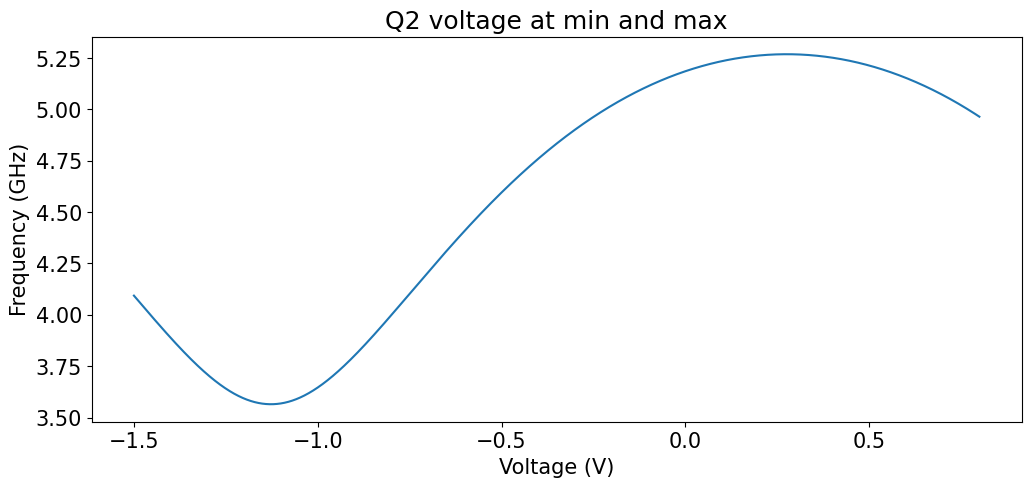

Q2 voltage at min: -1.127 V
Q2 voltage at max: 0.276 V
Q2 freq max: 5.27



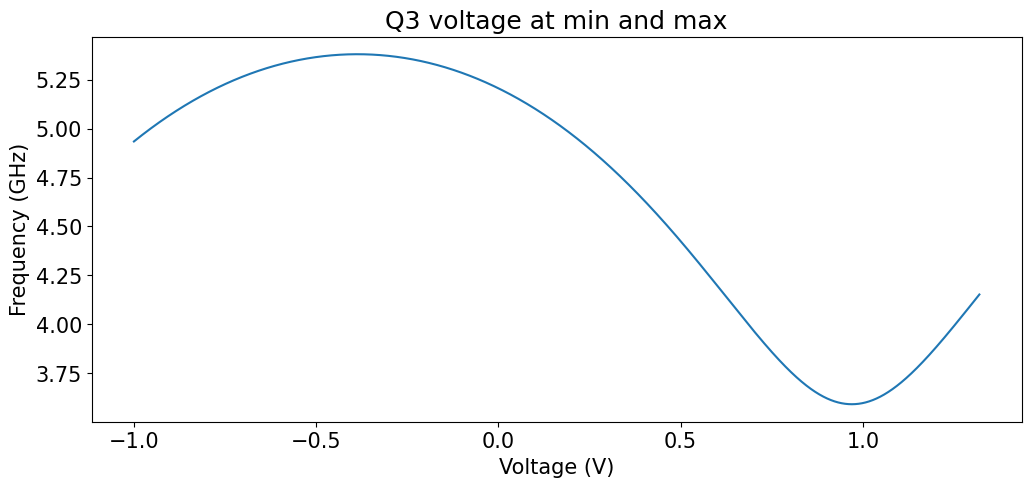

Q3 voltage at min: 0.97 V
Q3 voltage at max: -0.387 V
Q3 freq max: 5.38



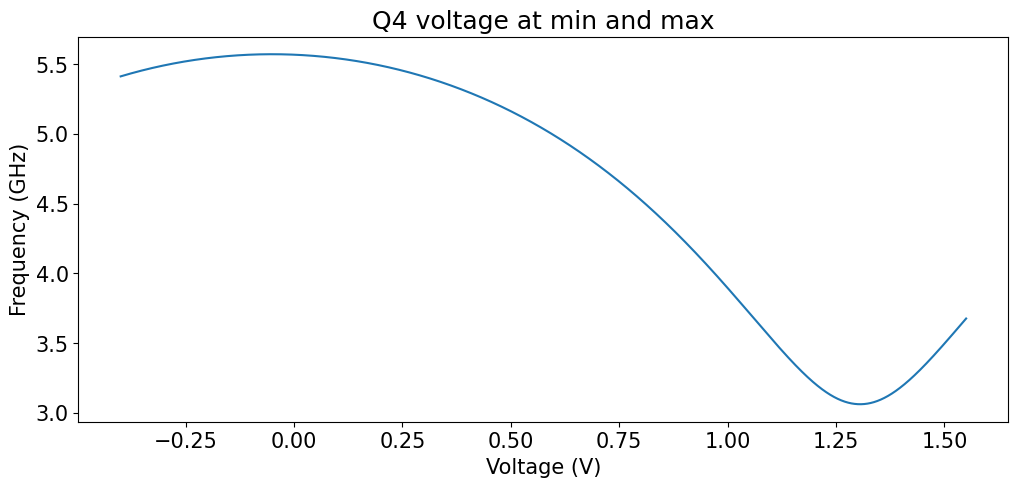

Q4 voltage at min: 1.305 V
Q4 voltage at max: -0.051 V
Q4 freq max: 5.57



In [29]:
### voltage at min/max

for qubit in extract_param_qubits:
    
    trianglemon_popt = qubit_to_trianglemon_popts[qubit]
    filtered_voltages = qubit_to_filtered_voltages[qubit]
    
    if qubit == 'Q2':
        fit_voltages = np.linspace(filtered_voltages[0], filtered_voltages[-1], 10001)
    elif qubit == 'Q3':
        fit_voltages = np.linspace(filtered_voltages[0], filtered_voltages[-1], 10001)
    else:
        fit_voltages = np.linspace(filtered_voltages[0], filtered_voltages[-1], 10001)
    fit_frequnecies = frequency_model_fit_trianglemon(fit_voltages, *trianglemon_popt)
    
    plt.plot(fit_voltages, fit_frequnecies)
    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (GHz)')
    
    plt.title(f'{qubit} voltage at min and max')
    
    plt.show()
    
    print(f'{qubit} voltage at min: {round(fit_voltages[np.argmin(fit_frequnecies)], 3)} V')
    print(f'{qubit} voltage at max: {round(fit_voltages[np.argmax(fit_frequnecies)], 3)} V') 
    print(f'{qubit} freq max: {round(np.max(fit_frequnecies),2)}')
    print()

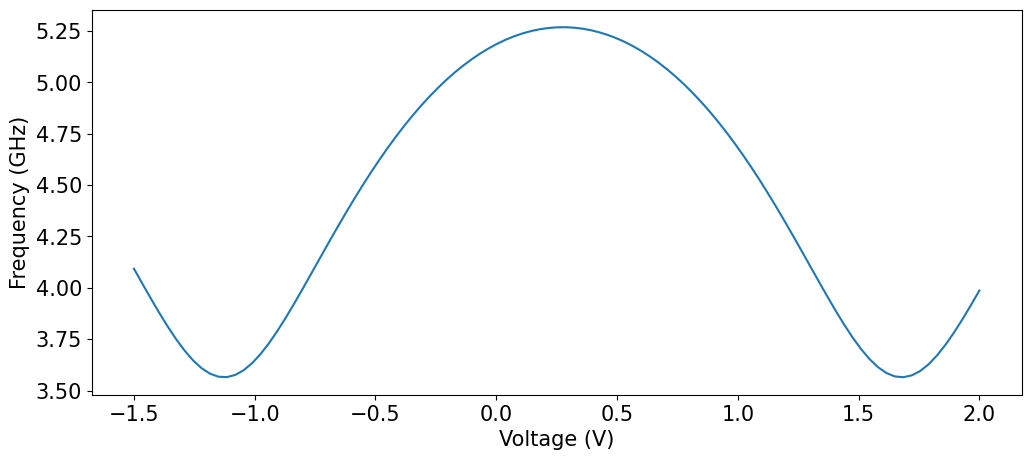

In [193]:
trianglemon_popt = qubit_to_trianglemon_popts['Q2']

fit_voltages = np.linspace(-1.5, 2, 101)
fit_frequnecies = frequency_model_fit_trianglemon(fit_voltages, *trianglemon_popt)

plt.plot(fit_voltages, fit_frequnecies)
plt.xlabel('Voltage (V)')
plt.ylabel('Frequency (GHz)')


plt.show()

In [200]:
print(list(np.round(fit_voltages, 5)))
print()
print(list(np.round(fit_frequnecies, 5)))


[-1.5, -1.465, -1.43, -1.395, -1.36, -1.325, -1.29, -1.255, -1.22, -1.185, -1.15, -1.115, -1.08, -1.045, -1.01, -0.975, -0.94, -0.905, -0.87, -0.835, -0.8, -0.765, -0.73, -0.695, -0.66, -0.625, -0.59, -0.555, -0.52, -0.485, -0.45, -0.415, -0.38, -0.345, -0.31, -0.275, -0.24, -0.205, -0.17, -0.135, -0.1, -0.065, -0.03, 0.005, 0.04, 0.075, 0.11, 0.145, 0.18, 0.215, 0.25, 0.285, 0.32, 0.355, 0.39, 0.425, 0.46, 0.495, 0.53, 0.565, 0.6, 0.635, 0.67, 0.705, 0.74, 0.775, 0.81, 0.845, 0.88, 0.915, 0.95, 0.985, 1.02, 1.055, 1.09, 1.125, 1.16, 1.195, 1.23, 1.265, 1.3, 1.335, 1.37, 1.405, 1.44, 1.475, 1.51, 1.545, 1.58, 1.615, 1.65, 1.685, 1.72, 1.755, 1.79, 1.825, 1.86, 1.895, 1.93, 1.965, 2.0]

[4.09321, 4.02006, 3.94797, 3.878, 3.8114, 3.74961, 3.69418, 3.64676, 3.60893, 3.58212, 3.56742, 3.56546, 3.57633, 3.59956, 3.63417, 3.67884, 3.73201, 3.79204, 3.85733, 3.92642, 3.99798, 4.07092, 4.14427, 4.21728, 4.28932, 4.35989, 4.42862, 4.4952, 4.5594, 4.62105, 4.68003, 4.73625, 4.78964, 4.84018, 4.8

### 3.4 Define functions for frequencies vs flux

In [30]:
qubit_to_function = {}
qubit_to_inverse_function = {}

function_qubits = ['Q2', 'Q3', 'Q4']
# function_qubits = ['Q4']

for qubit in function_qubits:
    
    trianglemon_popt = qubit_to_trianglemon_popts[qubit]
    
    x0, a, b, c, d, e_1 = trianglemon_popt
    
    
    # takes a flux value and outputs frequency
    def create_qubit_function(popt):
        x0, a, b, c, d, e_1 = popt
        return lambda x: frequency_model_fit_trianglemon((np.pi*x)/b + x0, *popt)
    
    qubit_function = create_qubit_function(trianglemon_popt)
    qubit_to_function[qubit] = qubit_function
    
    # takes a frequency value and outputs flux
    def create_qubit_inverse_function(qubit_function):
        def find_root(f, __qubit_function):
            bracket = (0, 0.5)

            if isinstance(f, (list, np.ndarray)):
                fluxes = np.empty(len(f))
                for i in range(len(f)):
                    root_function = lambda flux: __qubit_function(flux) - f[i]
                    result = root_scalar(root_function, bracket=bracket)
                    fluxes[i] = result.root
                return fluxes
            elif isinstance(f, (int, float)):
                root_function = lambda flux: __qubit_function(flux) - f
                result = root_scalar(root_function, bracket=bracket)
                return result.root
        return lambda f: find_root(f, qubit_function)
        
    
    qubit_to_inverse_function[qubit] = create_qubit_inverse_function(qubit_function)
    
frequency_vs_flux_q2 = qubit_to_function['Q2']
frequency_vs_flux_q3 = qubit_to_function['Q3']
frequency_vs_flux_q4 = qubit_to_function['Q4']

In [31]:
print(f'Q2: {frequency_vs_flux_q2(0.2977646407840279)} GHz')
print(f'Q3: {frequency_vs_flux_q3(-0.20959051036485465)} GHz')
print(f'Q4: {frequency_vs_flux_q4(-0.39692517561248286)} GHz')

Q2: 4.486143871781226 GHz
Q3: 4.9980502786592025 GHz
Q4: 3.8026929334738484 GHz


Q2: 4.911436175856207 GHz
Q3: 4.630835081294038 GHz 
Q4: 5.469147990889586 GHz

In [32]:
print(f'Q2: {frequency_vs_flux_q2(-0.20223535921597208)} GHz')
print(f'Q3: {frequency_vs_flux_q3(0.27418845576705264)} GHz')
print(f'Q4: {frequency_vs_flux_q4(0.10289059446857833)} GHz')

Q2: 4.911436175856207 GHz
Q3: 4.71474464548929 GHz
Q4: 5.469514508252519 GHz


In [33]:
print(f'Q2: {frequency_vs_flux_q2(-0.38342245989304813)} GHz')
print(f'Q3: {frequency_vs_flux_q3(0.35904381716510547)} GHz')
print(f'Q4: {frequency_vs_flux_q4(0.33534183348766183)} GHz')

Q2: 3.9977054006679626 GHz
Q3: 4.228140392413124 GHz
Q4: 4.358086322137996 GHz


In [34]:
print(f'Q4: {frequency_vs_flux_q4(0.35071129700524467)} GHz')

Q4: 4.2296482999506075 GHz


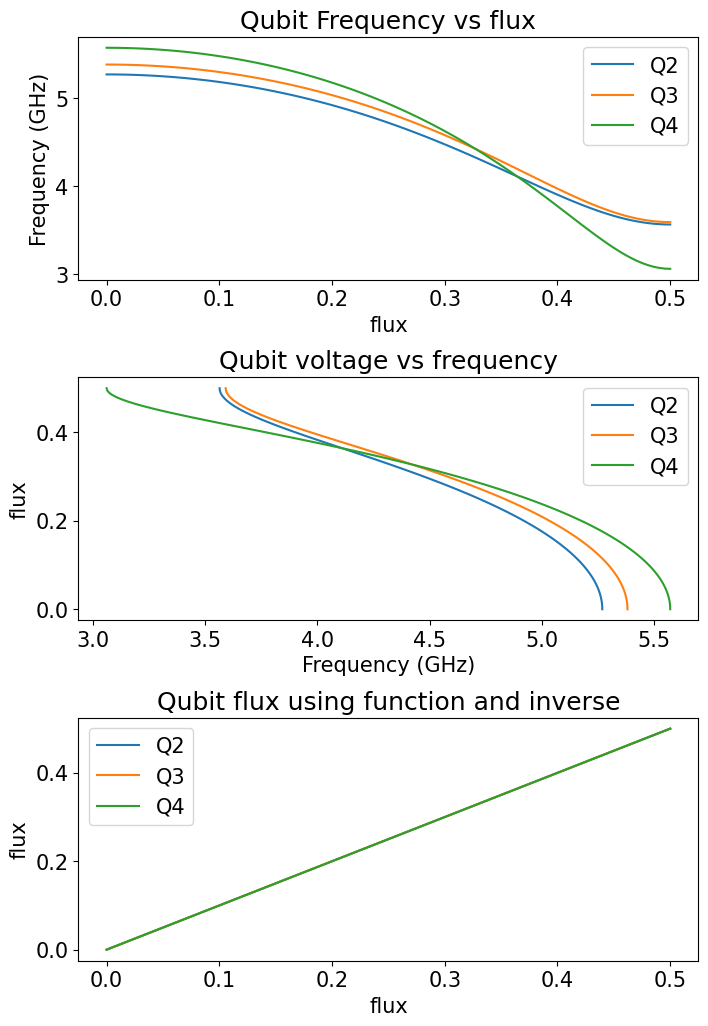

In [35]:
test_fluxes = np.linspace(0, 0.5, 101)

fig, axes = plt.subplots(3, 1, figsize=(8, 12))
plt.subplots_adjust(hspace=0.4)

for qubit in function_qubits:
    
    qubit_function = qubit_to_function[qubit]
    qubit_inverse_function = qubit_to_inverse_function[qubit]
    
    test_frequencies = qubit_function(test_fluxes)
    axes[0].plot(test_fluxes, test_frequencies, label=qubit)
    
    # inverse
    axes[1].plot(test_frequencies, qubit_inverse_function(test_frequencies), label=qubit)
    
    axes[2].plot(test_fluxes, qubit_inverse_function(test_frequencies), label=qubit)
    

axes[0].set_xlabel('flux')
axes[0].set_ylabel('Frequency (GHz)')
axes[0].set_title('Qubit Frequency vs flux')
axes[0].legend()

axes[1].set_ylabel('flux')
axes[1].set_xlabel('Frequency (GHz)')
axes[1].set_title('Qubit voltage vs frequency')
axes[1].legend()

axes[2].set_xlabel('flux')
axes[2].set_ylabel('flux')
axes[2].set_title('Qubit flux using function and inverse')
axes[2].legend()

plt.show()

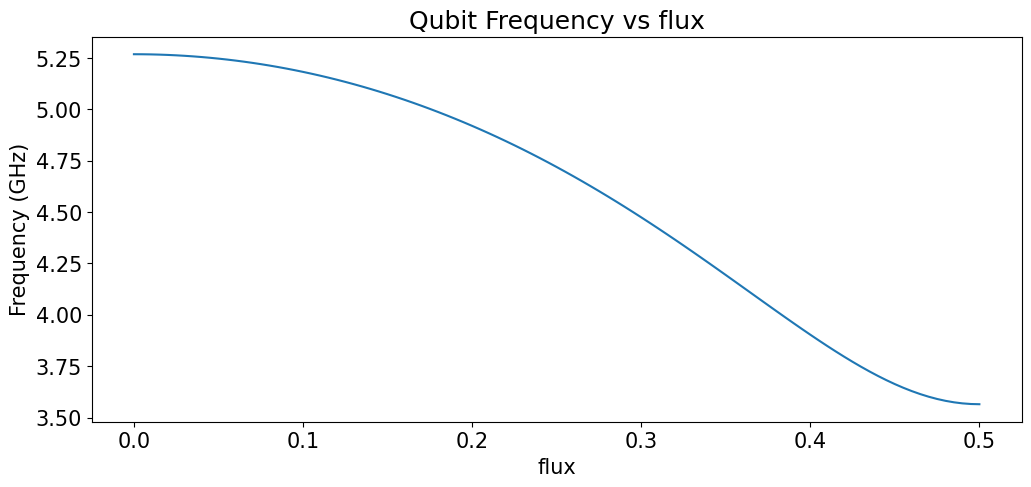

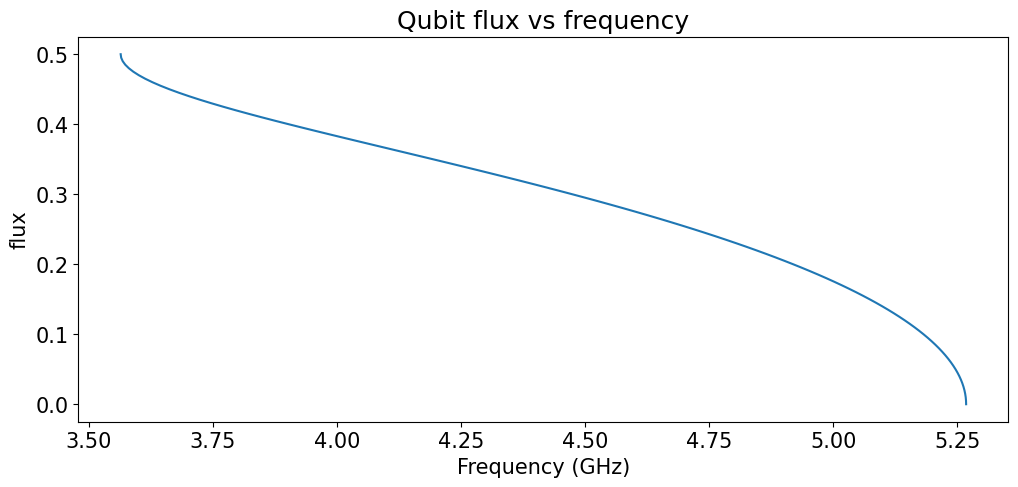

5.268086633299852
0.0


In [36]:
### Test Q2 inverse

# forward

test_fluxes = np.linspace(0, 0.5, 101)

trianglemon_popt = qubit_to_trianglemon_popts['Q2']

x0, a, b, c, d, e_1 = trianglemon_popt

test_function = lambda x: frequency_model_fit_trianglemon((np.pi*x)/b + x0, *trianglemon_popt)

test_frequencies = test_function(test_fluxes)


plt.plot(test_fluxes, test_frequencies)

plt.xlabel('flux')

plt.ylabel('Frequency (GHz)')
plt.title('Qubit Frequency vs flux')
plt.show()


# inverse

def test_Q2_inverse(f):
    
    bracket = (0, 0.5)
    
    if isinstance(f, (list, np.ndarray)):
        fluxes = np.empty(len(f))
        for i in range(len(f)):
            root_function = lambda flux: test_function(flux) - f[i]
            result = root_scalar(root_function, bracket=bracket)
            fluxes[i] = result.root
        return fluxes
    elif isinstance(f, (int, float)):
        root_function = lambda flux: test_function(flux) - f
        result = root_scalar(root_function, bracket=bracket)
        return result.root
    

plt.plot(test_frequencies, test_Q2_inverse(test_frequencies))
    
plt.ylabel('flux')

plt.xlabel('Frequency (GHz)')
plt.title('Qubit flux vs frequency')
plt.show()

print(test_function(0))
print(test_Q2_inverse(5.268086633299852))



In [188]:
Q2_flux = 0.5
Q3_flux = 0
Q4_flux = 0
print(f"Q2 at {Q2_flux} flux: {qubit_to_function['Q2'](Q2_flux)}")
print(f"Q3 at {Q3_flux} flux: {qubit_to_function['Q3'](Q3_flux)}")
print(f"Q4 at {Q4_flux} flux: {qubit_to_function['Q4'](Q4_flux)}")
print(qubit_to_function['Q2'](0.4) - qubit_to_function['Q2'](0.5))

Q2 at 0.5 flux: 3.5646783197764034
Q3 at 0 flux: 5.380193344608445
Q4 at 0 flux: 5.5704408332566
0.33842345881821556


# 4. Randomized Crosstalk Calibration

### 4.1 Import Data

In [130]:
def get_random_spec_data(filename):
    data1 = loadmat(filename)
    transAmpData1 = data1['transamp']
    specAmpData1 = data1['specamp']
    specPhaseData1 = data1['specphase']
    specFreqVector1 = data1['specfreq']
    random_voltages = data1['voltage_matrix']

    random_voltages = np.asarray(random_voltages)
    specFreqVector1 = np.asarray(specFreqVector1[0])*1e-9

    
    ### make copies of spec data 
    phase = specPhaseData1.copy()
    amp = specAmpData1.copy()

    ### remove average for better plotting
    for i in range(0, len(phase[:,1]) ):
        phase[i,:] = phase[i,:] - np.mean(phase[i,:])
        amp[i,:] = amp[i,:] - np.mean(amp[i,:])
    amp = amp#[::-1]
    Z = amp.copy()
    Z = np.asarray(Z)
    Z = np.transpose(Z)
    
    return random_voltages, specFreqVector1, Z

In [162]:
# Q2
Q2_filename_1 = r'V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax071624\2Tone4Qubit_NR_20240716_1451'
Q2_filename_2 = r'V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax071724\2Tone4Qubit_NR_20240717_1225'

# Q3
Q3_filename_1 = r'V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax071624\2Tone4Qubit_NR_20240716_1622'

# Q4
Q4_filename_1 = r'V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax071624\2Tone4Qubit_NR_20240716_1951'


# Q2 C12
Q2_C12_filename_1 = r'V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax071724\2Tone4Qubit_NR_20240717_1507'
Q2_C12_filename_2 = r'V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax072524\2Tone4Qubit_NR_20240725_1506'
Q2_C12_filename_test = r'V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax072524\2Tone4Qubit_NR_20240725_1705'
Q2_C12_filename_3 = r'V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax072624\2Tone4Qubit_NR_20240726_1523'

Q3_C34_filename_1 = r'C:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Jupyter Notebooks\crosstalk analysis\measurements\random_voltages\C34\2Tone4Qubit_NR_20240728_1536'

random_voltages, frequencies, transmission_data = get_random_spec_data(Q3_C34_filename_1)

Text(0, 0.5, 'Frequency (GHz)')

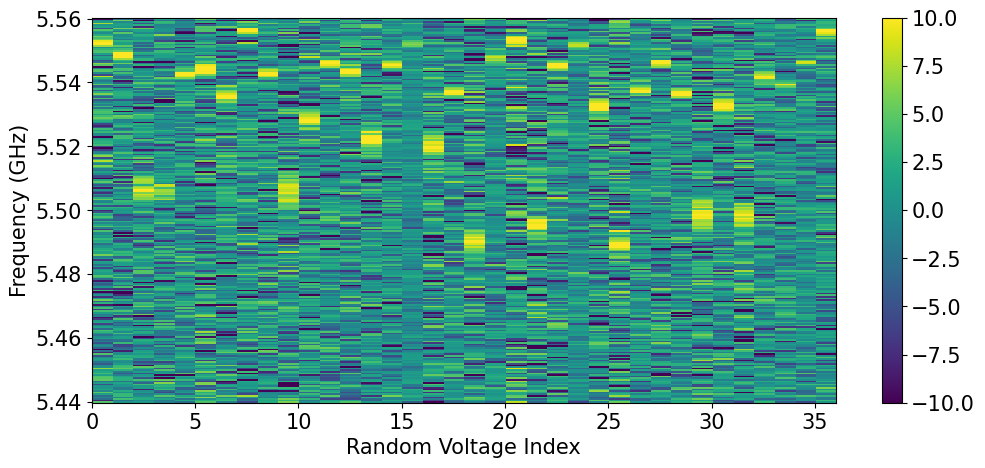

In [163]:
# plot transmission data

frequency_step = frequencies[1] - frequencies[0]

plt.imshow(transmission_data, vmin=-10, vmax=10, aspect='auto', interpolation='None', origin='lower', extent=(0, len(random_voltages), frequencies[0] - frequency_step/2, frequencies[-1] + frequency_step/2))
# plt.plot(indices_with_fit + 0.5, center_frequencies, marker='o', linestyle='', color='red')

plt.colorbar()
plt.xlabel('Random Voltage Index')
plt.ylabel('Frequency (GHz)')

### 4.2 Extract Peaks

In [164]:
def get_center_frequencies_randomized_voltages(frequencies, transmission_data, start_index=5, frequency_index_span=100, plot_fits=False):
    '''
    :param frequency_index_span: number of points around peak to try fit
    '''
    
#     center_frequencies = np.zeros(voltage_data.shape[1])
#     center_frequency_errors = np.zeros(voltage_data.shape[0])
    center_frequencies = []
    center_frequency_errors = []
    indices_with_fit = []
    
    
    if isinstance(start_index, int):
        start_indices = [start_index] * transmission_data.shape[1]
    else:
        start_indices = list(start_index)
    
    for i in range(transmission_data.shape[1]):
        
#         print(f'index: {i}')
        
        # find peak
        if i >= len(start_indices):
            start_index = start_indices[-1]
        else:
            start_index = start_indices[i]
        row = transmission_data[start_index:,i]
        
        peak_index = np.argmax(row) + start_index
        center_frequency_guess = frequencies[peak_index]
        
        
        # fit to lorentzian
        # restrict fit in range span around peak

        restricted_frequencies = frequencies[max(peak_index - frequency_index_span//2, 0):min(peak_index + frequency_index_span//2, len(frequencies))]
        restricted_row = transmission_data[max(peak_index - frequency_index_span//2, 0):min(peak_index + frequency_index_span//2, len(frequencies)),i]
        
        # apply savgol filter
        
        filtered_row = savgol_filter(restricted_row, 7, 1)
        
        bounds = ([restricted_frequencies[0], 0, 0, -np.inf], [restricted_frequencies[-1], np.inf, np.inf, np.inf])
        initial_guess = [center_frequency_guess, 0.001, 0.0001, 0]
        try:
            popt, pcov = curve_fit(lorentzian_fit, restricted_frequencies, filtered_row, p0=initial_guess, bounds=bounds)
        except:
            # if it fails, plot the data it was trying to fit
            plt.plot(restricted_frequencies, filtered_row, linestyle='', marker='o', label='data')
            plt.plot(restricted_frequencies, lorentzian_fit(restricted_frequencies, *initial_guess), label='guess')
            plt.xlabel('Frequency (MHz)')
            plt.title(f'Lorentzian fit for index {i}')
            plt.axvline(center_frequency_guess, color='red', linestyle=':')
            plt.legend()
            plt.show()
            
            print('Couldn\'t get a fit')
            
            # use max as the center frequency
            center_frequencies.append(restricted_frequencies[np.argmax(filtered_row)])
            indices_with_fit.append(i)
            center_frequency_errors.append(frequencies[-1] - frequencies[0])
            
            
        else:
            
            center_frequencies.append(popt[0])

            perr = np.sqrt(np.diag(pcov))
            center_frequency_errors.append(perr[0])

            indices_with_fit.append(i)
            
            if plot_fits:
                plt.plot(frequencies[start_index:], row, linestyle='', marker='o', label='data')

                fit_frequencies = np.linspace(frequencies[start_index], frequencies[-1], 1000)
                plt.plot(fit_frequencies, lorentzian_fit(fit_frequencies, *popt), label='fit')
                plt.axvline(center_frequency_guess, color='red', linestyle=':')
                plt.legend()

                plt.xlabel('Frequency (MHz)')
                plt.title(f'Lorentzian fit for index {i}')
                plt.show()

                print(f'Center frequency is {popt[0]} MHz')
            
    return indices_with_fit, center_frequencies, center_frequency_errors


In [165]:
qubit = 'Q2'
qubit = 'Q4'
filename = Q3_C34_filename_1

indices_with_fit = []
center_frequencies = []
center_frequency_errors = []

plot_fits = False

voltage_data, frequency_data, transmission_data = get_random_spec_data(filename)
start_index = 5

frequency_index_span = 50

file_indices_with_fit, file_frequencies, error = get_center_frequencies_randomized_voltages(frequency_data, transmission_data, start_index, frequency_index_span=frequency_index_span, plot_fits=plot_fits)

indices_with_fit.extend(file_indices_with_fit)
center_frequencies.extend(file_frequencies)
center_frequency_errors.extend(error)

indices_with_fit = np.array(indices_with_fit)
center_frequencies = np.array(center_frequencies)
center_frequency_errors = np.array(center_frequency_errors)

plt.show()

# sort data by voltage




[5.552551262440003, 5.548717768587937, 5.506467704248982, 5.506118213400742, 5.542666325078796, 5.544439609826842, 5.535813991321213, 5.556394713247542, 5.54284176735289, 5.505572001443642, 5.52811733287565, 5.5461898015989215, 5.543595542291532, 5.522490330696975, 5.546062782697839, 5.552286575842738, 5.520194734320028, 5.53718742826574, 5.490224590431302, 5.547391277375983, 5.55330784064483, 5.495275173276291, 5.545193271943951, 5.5515726980030715, 5.532646057601479, 5.4892366490325495, 5.537897140628434, 5.546593481829321, 5.5366866410422, 5.498708423561637, 5.532887949107032, 5.497540295207995, 5.541795942076761, 5.539036819225876, 5.546752679200417, 5.556131101832476]


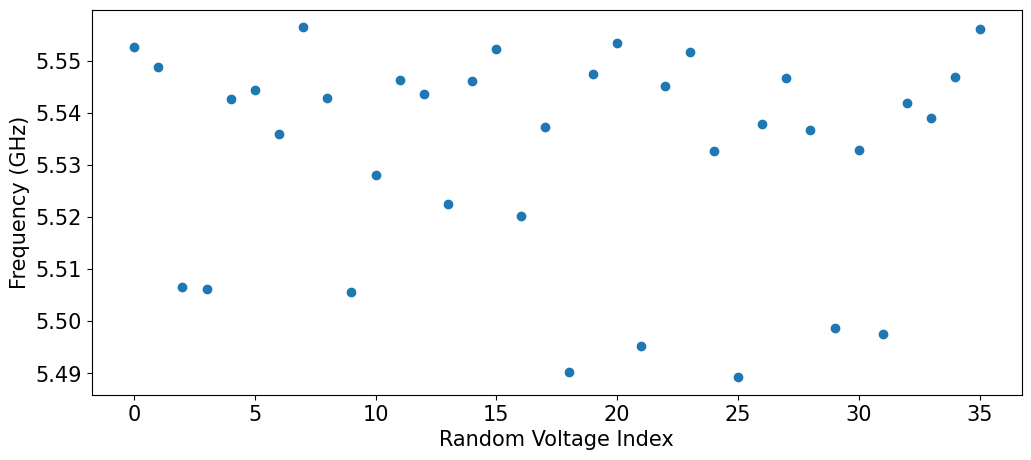

In [166]:
plt.plot(indices_with_fit, center_frequencies, marker='o', linestyle='')

plt.xlabel('Random Voltage Index')
plt.ylabel('Frequency (GHz)')

print('[', end='')
for i in range(len(center_frequencies) - 1):
    print(f'{center_frequencies[i]}, ', end='')
print(f'{center_frequencies[-1]}]')

### 4.3 Convert Frequencies to Flux

In [123]:
qubit_inverse_function = qubit_to_inverse_function[qubit]

fluxes = qubit_inverse_function(center_frequencies)

print(center_frequencies)
print(fluxes)

[4.50016573 4.49961969 4.49938804 4.50032559 4.49814273 4.49992063
 4.50008134 4.50035278 4.50009809 4.50002041 4.50027726 4.49994071
 4.49967432 4.50024178 4.49905375 4.49992343 4.50010032 4.50043773
 4.49977664 4.50059435 4.49984614 4.50004144 4.49965775 4.49820954
 4.49974191 4.50037234 4.49976328 4.49938705 4.49803751 4.50032474
 4.49991561 4.49974219 4.50037966 4.50038058 4.50048526 4.50008639
 4.49976449 4.50015718 4.50041946 4.50038483 4.50056915 4.50000544
 4.50000469 4.5001381  4.50004974 4.49992936 4.50022726 4.50047899
 4.50005975 4.50011743]
[0.29509364 0.29519804 0.29524233 0.29506307 0.29548029 0.29514051
 0.29510978 0.29505787 0.29510657 0.29512143 0.29507231 0.29513667
 0.2951876  0.2950791  0.29530622 0.29513997 0.29510615 0.29504162
 0.29516804 0.29501166 0.29515475 0.29511741 0.29519077 0.29546752
 0.29517468 0.29505413 0.29517059 0.29524252 0.29550038 0.29506323
 0.29514147 0.29517463 0.29505273 0.29505255 0.29503253 0.29510881
 0.29517036 0.29509528 0.29504511 0.29

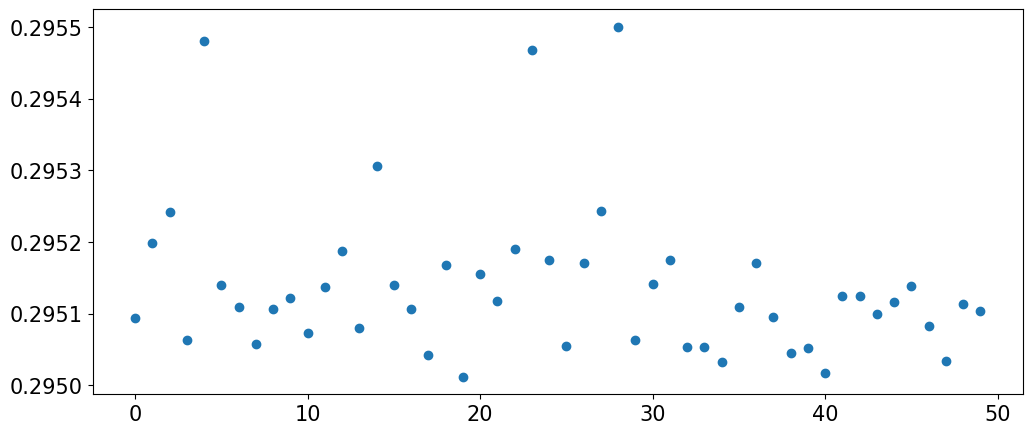

In [124]:
plt.plot(fluxes, marker='o', linestyle='')

In [125]:
print('[', end='')
for i in range(len(fluxes) - 1):
    print(f'{fluxes[i]}, ', end='')
print(f'{fluxes[-1]}]')

[0.2950936392987421, 0.29519804407605627, 0.2952423265603364, 0.29506306801942056, 0.29548028547857613, 0.2951405083100034, 0.2951097775612734, 0.2950578683876315, 0.2951065742759179, 0.2951214281553099, 0.295072311634605, 0.29513666903559704, 0.29518760139616357, 0.2950790963168394, 0.29530622029436226, 0.29513997275003734, 0.2951061480715071, 0.2950416205171088, 0.2951680393391523, 0.2950116643677704, 0.2951547508899339, 0.29511740787394897, 0.2951907692489146, 0.2954675228703208, 0.2951746790198587, 0.2950541263997631, 0.2951705927297803, 0.29524251724783074, 0.2955003824600484, 0.2950632313136149, 0.2951414684766794, 0.2951746251998004, 0.2950527276467552, 0.2950525517213204, 0.2950325302821383, 0.29510881238715975, 0.2951703625107996, 0.2950952757291677, 0.29504511493352675, 0.2950517386131087, 0.2950164846142104, 0.29512429090959413, 0.2951244352533125, 0.2950989244977834, 0.29511582021480026, 0.2951388384471055, 0.29508187245357625, 0.29503372944517153, 0.2951139060294059, 0.295